# **Russia Models**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from pmdarima.arima import auto_arima
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [3]:
data = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\APZIVA\Project 5\stock_price_data.csv')

In [4]:
def calculate_mape(actual=None, forecast= None):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100

# calculate_mape(actual= merged_data.y, forecast= merged_data.yhat)

In [5]:
def bollinger_bands(dataframe=None, forecast=None):
    # Create a copy of the dataframe to avoid modifying the original one
    dataframe = dataframe.copy()

    # Calculate the 20-period Simple Moving Average (SMA)
    dataframe['SMA'] = dataframe[forecast].rolling(window=20).mean()
    
    # Calculate the 20-period Standard Deviation (SD)
    dataframe['SD'] = dataframe[forecast].rolling(window=20).std()
    
    # Calculate the Upper Bollinger Band (UB) and Lower Bollinger Band (LB)
    dataframe['UB'] = dataframe['SMA'] + 2 * dataframe['SD']
    dataframe['LB'] = dataframe['SMA'] - 2 * dataframe['SD']

    print(dataframe.tail())
    return dataframe


In [6]:
def plot_bollinger_bands (dataframe = None,mdl_type = None, savefig = 'figure.png'):
    
    plt.figure(figsize=(15,8))
    
    # Plot y values
    plt.plot(dataframe['Date'], dataframe['Price'], label='Price', color='blue')
    
    # Plot Upper Bollinger Band (UB)
    plt.plot(dataframe['Date'], dataframe['UB'], label='Upper Bollinger Band (UB)', color='green', linestyle='--')
    
    # Plot Lower Bollinger Band (LB)
    plt.plot(dataframe['Date'], dataframe['LB'], label='Lower Bollinger Band (LB)', color='red', linestyle='--')
    
    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title(mdl_type + ':  '   +'Price, Upper Bollinger Band (UB) and Lower Bollinger Band (LB)')
    
    # Add legend
    plt.legend()

    # save graph
    plt.savefig(savefig)
    
    # Show plot
    plt.show()


In [7]:
data.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,31-Mar-21,291.02,294.00,294.42,290.26,47.00M,-0.76%
1,30-Mar-21,293.25,294.86,295.72,291.50,38.81M,-0.02%
2,29-Mar-21,293.30,289.72,294.09,289.26,43.68M,0.71%
3,26-Mar-21,291.22,288.63,292.75,288.32,56.07M,1.59%
4,25-Mar-21,286.66,286.50,287.03,283.85,35.22M,0.30%


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 311 entries, 0 to 310
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      311 non-null    object 
 1   Price     311 non-null    float64
 2   Open      311 non-null    float64
 3   High      311 non-null    float64
 4   Low       311 non-null    float64
 5   Vol.      311 non-null    object 
 6   Change %  311 non-null    object 
dtypes: float64(4), object(3)
memory usage: 17.1+ KB


In [9]:
# change 'Date' to a datetime object
data['Date'] = pd.to_datetime(data['Date'], format='%d-%b-%y')

In [10]:
data.dtypes

Date        datetime64[ns]
Price              float64
Open               float64
High               float64
Low                float64
Vol.                object
Change %            object
dtype: object

In [11]:
# sort data by Date

data = data.sort_values(by='Date')

In [12]:
# keep columnns
data = data[['Date', 'Price' ]]
print(data.head())
print(data.tail())

          Date   Price
310 2020-01-03  255.00
309 2020-01-06  253.90
308 2020-01-08  259.15
307 2020-01-09  257.99
306 2020-01-10  258.19
        Date   Price
4 2021-03-25  286.66
3 2021-03-26  291.22
2 2021-03-29  293.30
1 2021-03-30  293.25
0 2021-03-31  291.02


In [13]:
# **create train_data**
train_data = data[data.Date <= '2020-12-31']

print(train_data.Date.min())
print(train_data.Date.max())

2020-01-03 00:00:00
2020-12-30 00:00:00


In [14]:
# **create test_data**
test_data =data[data.Date > '2020-12-31']

print('min',test_data.Date.min())
print('max  ',test_data.max())

min 2021-01-04 00:00:00
max   Date     2021-03-31 00:00:00
Price                  293.3
dtype: object


In [15]:
def lineplot(x,y,data_,title_):
    sns.set(rc = {'figure.figsize':(15,8)})
    # Bigger than normal fonts
    sns.set(font_scale=1.5)
    sns.set_style('darkgrid')
    chart = sns.lineplot(x = x, y = y, data = data_)
    chart.set(title=title_)
    plt.show()

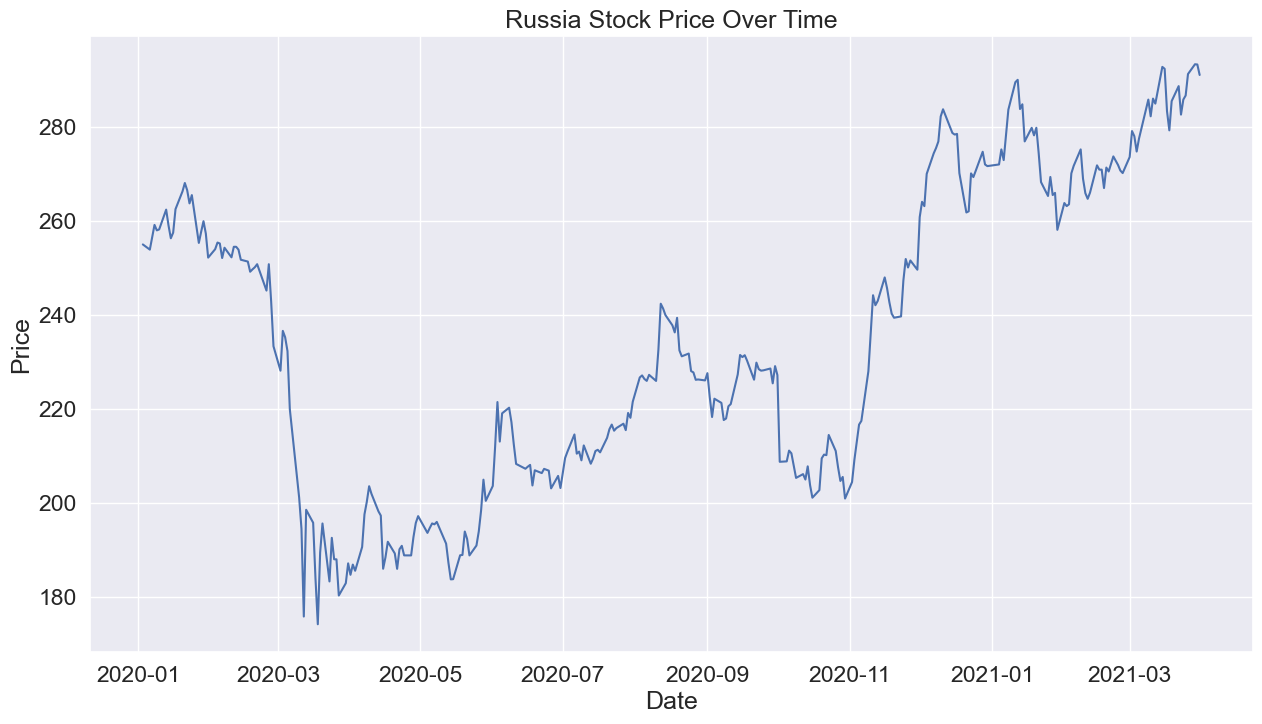

In [16]:
lineplot(x='Date',y='Price',data_=data,title_='Russia Stock Price Over Time')

# **Russia: Moving Average**

Calculate the 30-day moving average using the training data

In [18]:
# Calculate the 30-day moving average using the training data

# Note: window size is the number of days you go back to calculate
window_size = 30
train_data['30_day_MA'] = train_data['Price'].rolling(window=window_size).mean()

# Define the forecast period (Q1 2021)
forecast_period =pd.bdate_range(start='2021-01-01', end='2021-03-31')

# Initialize a DataFrame to store the forecasted values
forecast_df = pd.DataFrame({'Date': forecast_period, 'Forecast': np.nan})

print(forecast_df.head())

# Use the last available 'window_size' days from the training data to start the forecast # last_window_data
last_window_data = train_data['Price'].iloc[-window_size:].values #generates Numpy array

# Extend the forecast using the moving average logic
for i, date in enumerate(forecast_period):
    forecast_value = np.mean(last_window_data)
    forecast_df.at[i, 'Forecast'] = forecast_value
    # Update the window data by appending the forecast value and removing the oldest value
    last_window_data = np.append(last_window_data[1:], forecast_value)

print(forecast_df.head())

        Date  Forecast
0 2021-01-01       NaN
1 2021-01-04       NaN
2 2021-01-05       NaN
3 2021-01-06       NaN
4 2021-01-07       NaN
        Date    Forecast
0 2021-01-01  265.284333
1 2021-01-04  266.118144
2 2021-01-05  267.008083
3 2021-01-06  267.918352
4 2021-01-07  268.604630


C:\Users\dgarb\AppData\Local\Temp\ipykernel_7748\3121611826.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['30_day_MA'] = train_data['Price'].rolling(window=window_size).mean()


In [19]:
# Merge test_data with forecast_df on 'Date'
merged_data = pd.merge(test_data, forecast_df, on='Date', how='inner')
merged_data.head()

,Date,Price,Forecast
0,2021-01-04,272.00,266.118144
1,2021-01-05,275.20,267.008083
2,2021-01-06,272.93,267.918352
3,2021-01-08,283.64,269.161118
4,2021-01-11,289.49,269.796489


**Moving Average MAPE Score**

In [21]:
print('Moving Average MAPE Score')

calculate_mape(merged_data.Price, merged_data.Forecast)

Moving Average MAPE Score


3.1272017339574236

In [22]:
russia_dict = dict()
russia_dict['Moving Average MAPE Score'] = 3.1272017339574236

# **Russia: Exponential Smoothing**

In [24]:
import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Assuming data is already loaded in a DataFrame named 'data'
# Fit the model using the 'Price' column
model = ExponentialSmoothing(train_data['Price'], trend='additive', seasonal=None)
fit = model.fit()

# Generate business days for the first quarter of 2021
forecast_dates = pd.date_range(start='2021-01-01', end='2021-03-31', freq='B')
steps = len(forecast_dates)

# Forecast for the first quarter of 2021
forecast = fit.forecast(steps=steps)

# Combine the forecast with the dates for the forecast period
forecast_df = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})

# Print or plot the forecast
print(forecast_df)


          Date    Forecast
250 2021-01-01  271.716867
251 2021-01-04  271.783734
252 2021-01-05  271.850602
253 2021-01-06  271.917469
254 2021-01-07  271.984336
..         ...         ...
309 2021-03-25  275.662033
310 2021-03-26  275.728900
311 2021-03-29  275.795767
312 2021-03-30  275.862635
313 2021-03-31  275.929502

[64 rows x 2 columns]


C:\Users\dgarb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dgarb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dgarb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [25]:
merged_data_exp = pd.merge(test_data, forecast_df, on='Date', how='inner')
merged_data_exp.head()

,Date,Price,Forecast
0,2021-01-04,272.00,271.783734
1,2021-01-05,275.20,271.850602
2,2021-01-06,272.93,271.917469
3,2021-01-08,283.64,272.051203
4,2021-01-11,289.49,272.118071


In [26]:
merged_data_exp.columns

Index(['Date', 'Price', 'Forecast'], dtype='object')

In [27]:
print('Exponential Smoothing MAPE Score')
calculate_mape(merged_data_exp.Price, merged_data_exp.Forecast)

Exponential Smoothing MAPE Score


2.7030349698597034

In [28]:
russia_dict['Exponential Smoothing MAPE Score'] = 2.7030349698597034

# **Russia: ARIMA**

In [30]:
# Extract the 'Price' series
train_prices = train_data['Price']
test_prices = test_data['Price']

# Fit auto_arima model
model = auto_arima(train_prices,star1_p=1,start_q=1,max_p=5,max_q=5 ,seasonal=False, trace=True, suppress_warnings=True)
print(model.summary())

# Forecast the first quarter of 2021 (assuming 90 business days)
n_periods = len(test_prices)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Combine forecast with dates
forecast_dates = test_data['Date']
forecast = pd.Series(forecast, index=forecast_dates)


Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1504.526, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1499.638, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1501.228, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1501.180, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1497.685, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=1502.372, Time=0.10 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.409 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  250
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -747.842
Date:                Thu, 22 Aug 2024   AIC                           1497.685
Time:                        16:45:29   BIC                           1501.202
Sample:                             0   HQIC                          1499.101
          

C:\Users\dgarb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dgarb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [31]:
forecast_df_ARIMA = pd.DataFrame({
    'Date': test_data['Date'],
    'Forecast': forecast
})


C:\Users\dgarb\AppData\Local\Temp\ipykernel_7748\338654661.py:1: RuntimeWarning: '<' not supported between instances of 'Timestamp' and 'int', sort order is undefined for incomparable objects.
  forecast_df_ARIMA = pd.DataFrame({


In [32]:
# forecast_df_ARIMA.head()

In [33]:
# Merge test_data with forecast_df on 'Date'
merged_data_ARIMA = pd.merge(test_data, forecast_df_ARIMA, on='Date', how='inner')



In [34]:
# print(merged_data_ARIMA.head())

In [35]:
print('ARIMA MAPE Score')
calculate_mape(merged_data_ARIMA.Price,merged_data_ARIMA.Forecast)

ARIMA MAPE Score


nan

In [36]:
russia_dict['ARIMA MAPE Score'] = 2.914816247114103

# **Russia: LSTM**

In [38]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data = scaler.fit_transform(train_data[['Price']])

In [39]:
# Create a function to prepare the data for LSTM
def create_dataset(data, time_step=1):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [40]:
time_step = 60
X_train, y_train = create_dataset(scaled_train_data, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)


In [41]:
# Build the LSTM model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Forecast the first quarter of 2021
n_future_days = 60  # Assuming there are 60 trading days in the first quarter of 2021
x_input = scaled_train_data[-time_step:].reshape(1, -1)#=>scaled_train_data[-60:]
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Generate predictions for the next 60 days
lst_output = []
i = 0
while i < n_future_days:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Transform the forecasted data back to original scale
forecasted_stock_prices = scaler.inverse_transform(lst_output)

# Create a date range for the forecasted data
last_date = train_data['Date'].max()
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future_days, freq='B')  # Business days


C:\Users\dgarb\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


189/189 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - loss: 0.0589


In [42]:
print(type(forecast_dates))

print(type(forecasted_stock_prices))
forecasted_stock_prices = forecasted_stock_prices.reshape(-1)


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'numpy.ndarray'>


In [43]:
dict_forecast = {'forecast_dates':list(forecast_dates) , 'forecasted_stock_prices':list(forecasted_stock_prices)}
forecast_df_LSTM = pd.DataFrame(dict_forecast)

In [44]:
forecast_df_LSTM.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   forecast_dates           60 non-null     datetime64[ns]
 1   forecasted_stock_prices  60 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB


In [45]:
merged_data_LSTM = test_data.merge(forecast_df_LSTM, left_on='Date', right_on='forecast_dates', how='inner')

merged_data_LSTM.head()

,Date,Price,forecast_dates,forecasted_stock_prices
0,2021-01-04,272.00,2021-01-04,262.282856
1,2021-01-05,275.20,2021-01-05,261.411898
2,2021-01-06,272.93,2021-01-06,260.443929
3,2021-01-08,283.64,2021-01-08,258.368137
4,2021-01-11,289.49,2021-01-11,257.307556


In [46]:
merged_data_LSTM = merged_data_LSTM.drop(columns = ['forecast_dates'])

In [47]:
merged_data_LSTM = merged_data_LSTM[['Date', 'Price','forecasted_stock_prices']]

In [48]:
merged_data_LSTM.head()

,Date,Price,forecasted_stock_prices
0,2021-01-04,272.00,262.282856
1,2021-01-05,275.20,261.411898
2,2021-01-06,272.93,260.443929
3,2021-01-08,283.64,258.368137
4,2021-01-11,289.49,257.307556


In [49]:
merged_data_LSTM.columns = ['Date', 'Price', 'Forecast']

**LSTM MAPE Score**

In [51]:
print('LSTM MAPE Score')
calculate_mape(merged_data_LSTM.Price, merged_data_LSTM.Forecast)

LSTM MAPE Score


12.816614568049117

In [52]:
russia_dict['LSTM MAPE Score'] = 17.516170351729304

# **Russia: Prophet**

In [54]:
data.head()

,Date,Price
310,2020-01-03,255.00
309,2020-01-06,253.90
308,2020-01-08,259.15
307,2020-01-09,257.99
306,2020-01-10,258.19


In [55]:
# Prepare data for Prophet

df = pd.DataFrame()
df['ds'] = pd.to_datetime(data['Date'])
df['y'] = data['Price']
print(df.head())

            ds       y
310 2020-01-03  255.00
309 2020-01-06  253.90
308 2020-01-08  259.15
307 2020-01-09  257.99
306 2020-01-10  258.19


In [56]:
# **create train_data**
df_train = df[df.ds <= '2020-12-31' ]

print(df_train.head())

            ds       y
310 2020-01-03  255.00
309 2020-01-06  253.90
308 2020-01-08  259.15
307 2020-01-09  257.99
306 2020-01-10  258.19


In [57]:
# **create test_data**
df_test = df[df.ds > '2020-12-31' ]

print(df_test.head())

           ds       y
60 2021-01-04  272.00
59 2021-01-05  275.20
58 2021-01-06  272.93
57 2021-01-08  283.64
56 2021-01-11  289.49


In [58]:
def calculate_mape(actual=None, forecast= None):
    actual = np.array(actual)
    forecast = np.array(forecast)
    return np.mean(np.abs((actual - forecast) / actual)) * 100


In [59]:
def func_test_forecast_MAPE(
params = None,
country = 'Russia',
df_train = df_train):

    # Initialize the Prophet model with hyperparameters
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True
    )
    
    # Add country holidays
    model.add_country_holidays(country_name=country) 
    
    # Fit the model
    model.fit(df_train)   
    
    # Create a DataFrame for future predictions (Business days only)
    future = model.make_future_dataframe(periods=90, freq='B')
    
    # Predict future values
    forecast = model.predict(future)
      
    forecast_df = forecast[['ds','yhat']]
    
    forecast_df.shape
    mask = forecast_df.ds > '2020-12-31'
    
    
    print(' ') 
    print('params = ', params)
    
    forecast_df = forecast_df[mask]
    
    print('forecast_df.shape = ', forecast_df.shape)
    
    merged_data = pd.merge(df_test, forecast_df, on='ds', how='inner')
    print('merged_data.shape = ', merged_data.shape)
    print(' ')
    MAPE_Score = calculate_mape(actual=merged_data.y, forecast=merged_data.yhat)
    print('MAPE_Score = ', MAPE_Score)
    print(' ')
    return forecast_df, merged_data, MAPE_Score

In [60]:
forecast_Prophet, merged_data_Prophet, MAPE_Score = func_test_forecast_MAPE(
params  = {
    'changepoint_prior_scale': 0.015,
    'seasonality_prior_scale': 0.0125,
    'holidays_prior_scale': 0.01,
    'seasonality_mode': 'additive'
}
,
country = 'Russia',
df_train = df_train)

16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:44 - cmdstanpy - INFO - Chain [1] done processing


 
params =  {'changepoint_prior_scale': 0.015, 'seasonality_prior_scale': 0.0125, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}
forecast_df.shape =  (89, 2)
merged_data.shape =  (60, 3)
 
MAPE_Score =  9.246960346626697
 


In [61]:
forecast_Prophet, merged_data_Prophet, MAPE_Score = func_test_forecast_MAPE(
params  = {
    'changepoint_prior_scale': 0.015,
    'seasonality_prior_scale': 0.0125,
    'holidays_prior_scale': 0.01,
    'seasonality_mode': 'multiplicative'
}
,
country = 'Russia',
df_train = df_train)

16:45:44 - cmdstanpy - INFO - Chain [1] start processing
16:45:45 - cmdstanpy - INFO - Chain [1] done processing


 
params =  {'changepoint_prior_scale': 0.015, 'seasonality_prior_scale': 0.0125, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
forecast_df.shape =  (89, 2)
merged_data.shape =  (60, 3)
 
MAPE_Score =  9.584388094104703
 


In [62]:

forecast_Prophet, merged_data_Prophet, MAPE_Score = func_test_forecast_MAPE(
params = {'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
,
country = 'Russia',
df_train = df_train)

16:45:45 - cmdstanpy - INFO - Chain [1] start processing
16:45:45 - cmdstanpy - INFO - Chain [1] done processing


 
params =  {'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
forecast_df.shape =  (89, 2)
merged_data.shape =  (60, 3)
 
MAPE_Score =  8.489201754904997
 


In [63]:
# forecast_df, merged_data, MAPE_train_test
forecast_Prophet, merged_data_Prophet, MAPE_Score = func_test_forecast_MAPE(
params = {
    'changepoint_prior_scale': 0.0375,
    'seasonality_prior_scale': 0.0125,
    'holidays_prior_scale': 0.01,
    'seasonality_mode': 'additive'
}
,
country = 'Russia',
df_train = df_train)

16:45:45 - cmdstanpy - INFO - Chain [1] start processing
16:45:45 - cmdstanpy - INFO - Chain [1] done processing


 
params =  {'changepoint_prior_scale': 0.0375, 'seasonality_prior_scale': 0.0125, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}
forecast_df.shape =  (89, 2)
merged_data.shape =  (60, 3)
 
MAPE_Score =  8.076721806261045
 


In [64]:
merged_data_Prophet.shape

(60, 3)

In [65]:

print(merged_data_Prophet.head())
print(merged_data_Prophet.tail())

          ds       y        yhat
0 2021-01-04  272.00  273.182647
1 2021-01-05  275.20  275.454530
2 2021-01-06  272.93  277.619543
3 2021-01-08  283.64  278.810900
4 2021-01-11  289.49  281.840376
           ds       y        yhat
55 2021-03-25  286.66  239.733587
56 2021-03-26  291.22  240.183266
57 2021-03-29  293.30  242.640825
58 2021-03-30  293.25  244.837866
59 2021-03-31  291.02  246.891954


In [66]:
print('Prophet MAPE Score')
calculate_mape(actual= merged_data_Prophet.y, forecast= merged_data_Prophet.yhat)

Prophet MAPE Score


8.076721806261045

In [67]:
russia_dict['Prophet MAPE Score'] =  8.076721806261045

In [68]:
df_b = bollinger_bands(dataframe=merged_data_Prophet, forecast='yhat')

           ds       y        yhat         SMA         SD          UB  \
55 2021-03-25  286.66  239.733587  255.628079  17.106306  289.840691   
56 2021-03-26  291.22  240.183266  253.316972  15.802001  284.920973   
57 2021-03-29  293.30  242.640825  251.229736  14.153212  279.536159   
58 2021-03-30  293.25  244.837866  249.596414  12.779719  275.155852   
59 2021-03-31  291.02  246.891954  248.136607  11.159106  270.454820   

            LB  
55  221.415468  
56  221.712970  
57  222.923313  
58  224.036976  
59  225.818395  


In [69]:
df_b.columns 

Index(['ds', 'y', 'yhat', 'SMA', 'SD', 'UB', 'LB'], dtype='object')

In [70]:
df_b.columns = ['Date', 'Price', 'Forecast', 'SMA', 'SD', 'UB', 'LB']

In [71]:
df_b.tail()

,Date,Price,Forecast,SMA,SD,UB,LB
55,2021-03-25,286.66,239.733587,255.628079,17.106306,289.840691,221.415468
56,2021-03-26,291.22,240.183266,253.316972,15.802001,284.920973,221.712970
57,2021-03-29,293.30,242.640825,251.229736,14.153212,279.536159,222.923313
58,2021-03-30,293.25,244.837866,249.596414,12.779719,275.155852,224.036976
59,2021-03-31,291.02,246.891954,248.136607,11.159106,270.454820,225.818395


In [164]:
print('Russia: MAPE Scores')
print(' ')
for k,v in russia_dict.items():
    print(k,' ',v)

Russia: MAPE Scores
 
Moving Average MAPE Score   3.1272017339574236
Exponential Smoothing MAPE Score   2.7030349698597034
ARIMA MAPE Score   2.914816247114103
LSTM MAPE Score   17.516170351729304
Prophet MAPE Score   8.076721806261045


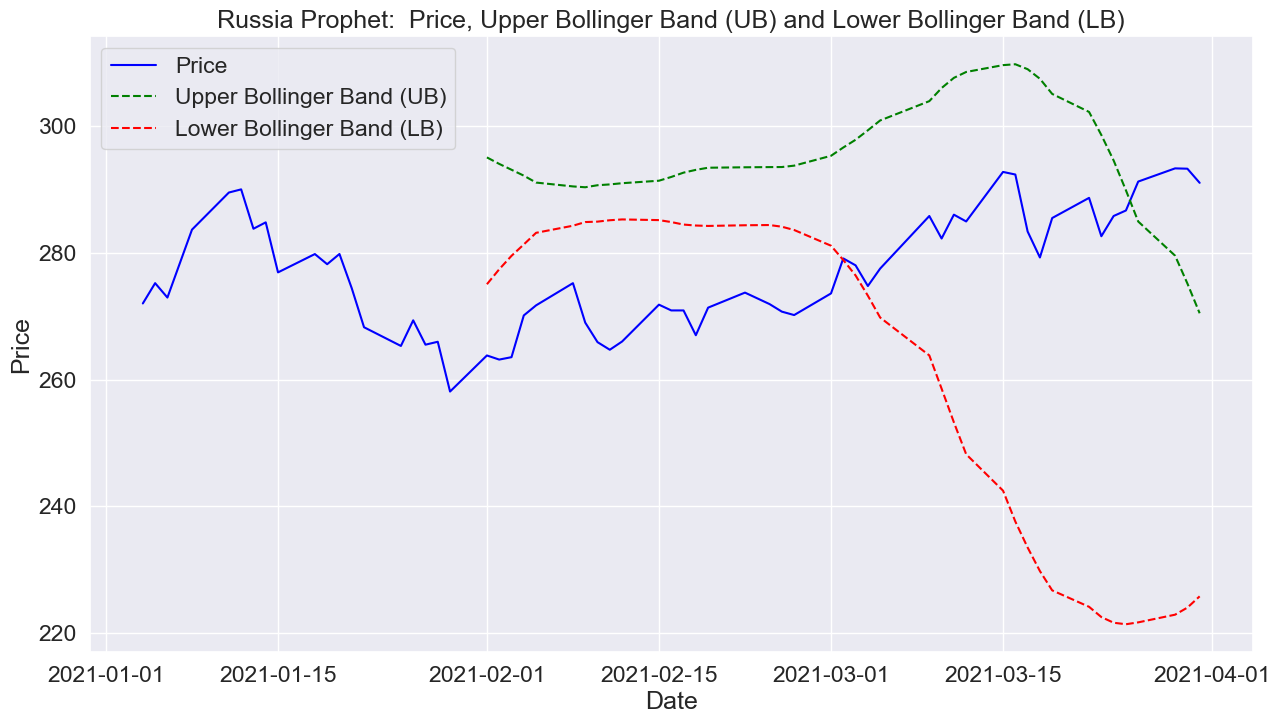

In [72]:
plot_bollinger_bands (dataframe = df_b, mdl_type = 'Russia Prophet',savefig = 'Rusia Bollinger Band Graph Final .png')

**Russia Strategy**

    For the month of February buy
    For the month of March hold since the price for the most part is between the Bollinger Bands
    

# **Turkey**

In [77]:
data2 = pd.read_csv(r'C:\Users\dgarb\OneDrive\Documents\APZIVA\Project 5\Turkey - Koc Holding AS (KCHOL).csv')

print(data2.head())
print(data2.tail())
print(' ')
print(data2.info())

def convert_date(date_string):
    date_datetime = pd.to_datetime(date_string)
    return date_datetime

data2['Date'] = convert_date(data2.Date)
print(' ')
print(data2.dtypes)

# keep only what is needed
data2 = data2[['Date', 'Price']]
print(data2.head()) 

           Date  Price   Open   High    Low    Vol. Change %
0  Mar 31, 2021  19.41  19.42  19.63  19.27  13.14M   -0.46%
1  Mar 30, 2021  19.50  19.12  19.81  19.03  21.05M    2.09%
2  Mar 29, 2021  19.10  19.24  19.67  19.10  16.56M   -0.78%
3  Mar 26, 2021  19.25  20.28  20.36  19.10  21.35M   -3.85%
4  Mar 25, 2021  20.02  20.50  20.86  20.02  15.93M   -1.48%
             Date  Price   Open   High    Low   Vol. Change %
311  Jan 07, 2020  19.93  20.22  20.28  19.92  2.89M   -0.75%
312  Jan 06, 2020  20.08  20.34  20.34  19.97  1.94M   -1.08%
313  Jan 03, 2020  20.30  20.30  20.44  19.97  3.31M   -0.39%
314  Jan 02, 2020  20.38  20.42  20.44  20.24  2.53M    0.30%
315           NaN    NaN    NaN    NaN    NaN    NaN      NaN
 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 316 entries, 0 to 315
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      315 non-null    object 
 1   Price     315 non-null    float64


In [78]:
# sort data by Date
data2 = data2.sort_values(by='Date')

In [79]:
data2.head()

,Date,Price
314,2020-01-02,20.38
313,2020-01-03,20.30
312,2020-01-06,20.08
311,2020-01-07,19.93
310,2020-01-08,19.94


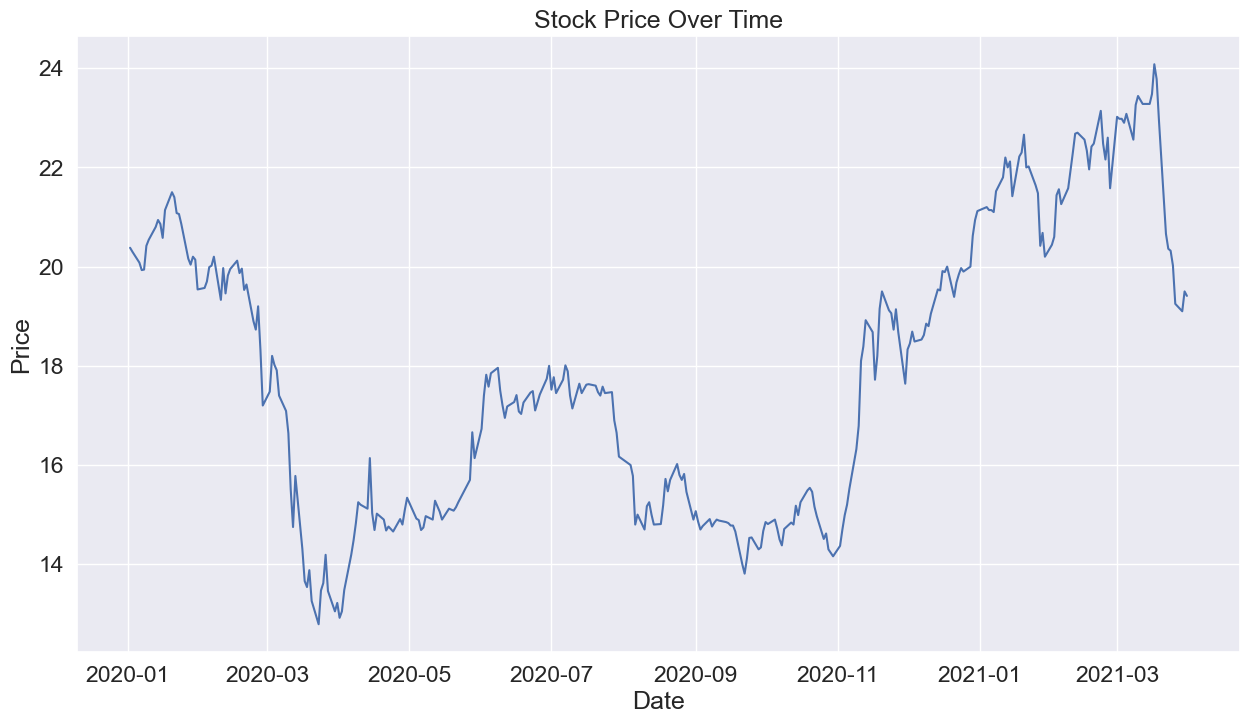

In [80]:
lineplot(x='Date',y='Price',data_=data2,title_='Stock Price Over Time')

In [81]:
# # **create train_data**
train_data2 = data2[data2.Date <= '2020-12-31']

print(train_data2.Date.min())
print(train_data2.Date.max())

# **create test_data**
test_data2 =data2[data2.Date > '2020-12-31']

print('min',test_data2.Date.min())
print('max  ',test_data2.max())

2020-01-02 00:00:00
2020-12-31 00:00:00
min 2021-01-04 00:00:00
max   Date     2021-03-31 00:00:00
Price                  24.08
dtype: object


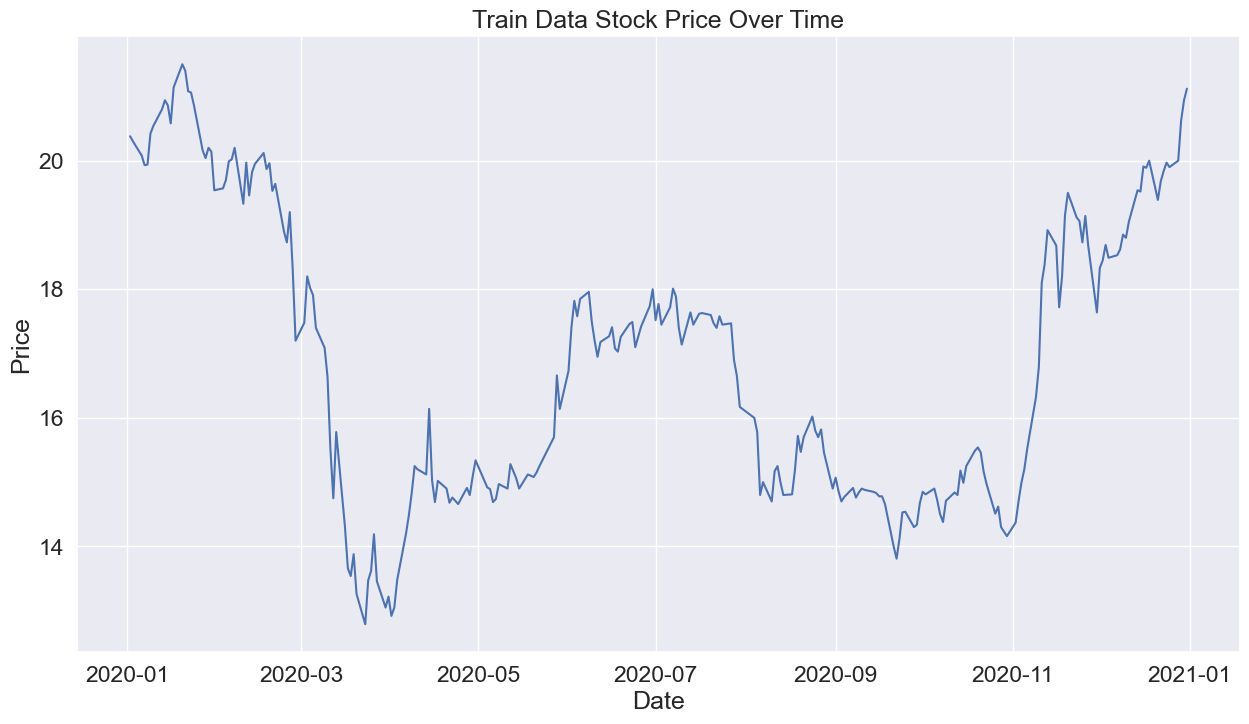

In [82]:
lineplot(x='Date',y='Price',data_=train_data2,title_='Train Data Stock Price Over Time')

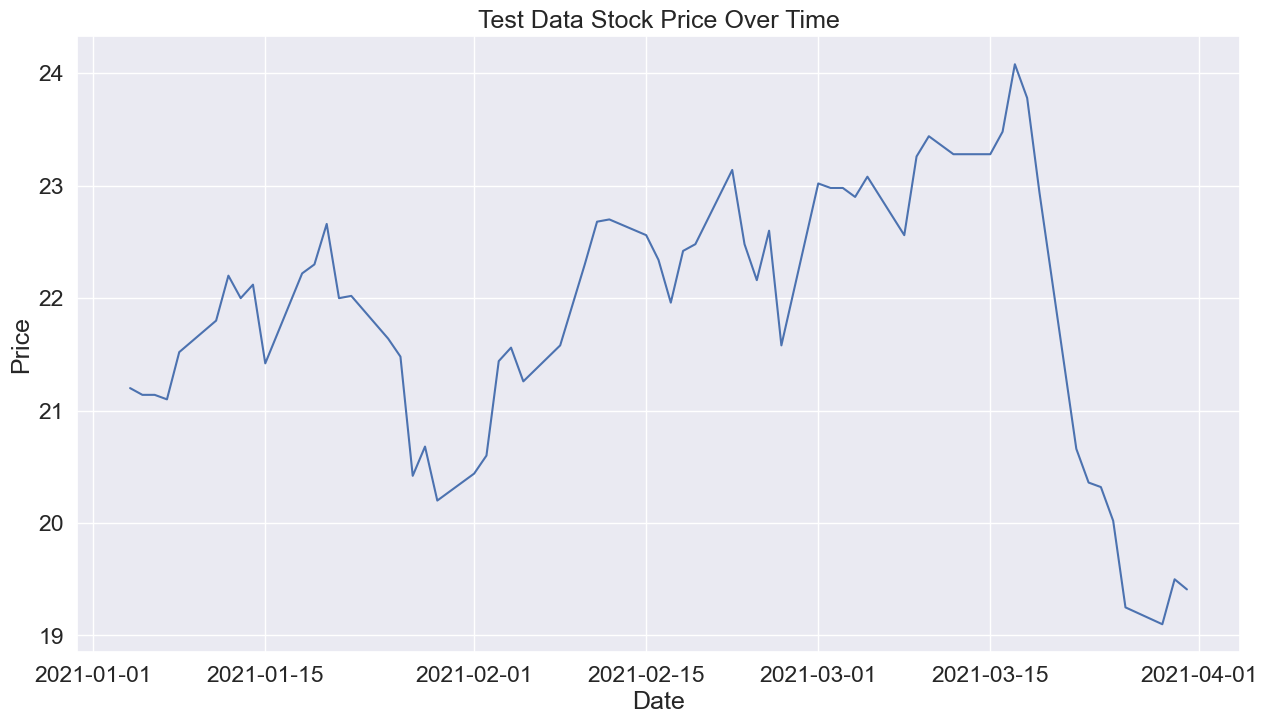

In [83]:
lineplot(x='Date',y='Price',data_=test_data2,title_='Test Data Stock Price Over Time')

# **Turkey: Moving Average**

Calculate the 30-day moving average using the training data2

In [85]:
# Calculate the 30-day moving average using the training data2

# Note: window size is the number of days you go back to calculate
window_size = 30
train_data2['30_day_MA'] = train_data2['Price'].rolling(window=window_size).mean()

# Define the forecast period (Q1 2021)
 
forecast_period =pd.bdate_range(start='2021-01-01', end='2021-03-31')

# Initialize a DataFrame to store the forecasted values
forecast_comparison = pd.DataFrame({'Date': forecast_period, 'Forecast': np.nan})

# Use the last available 'window_size' days from the training data2 to start the forecast
last_window_data2 = train_data2['Price'].iloc[-window_size:].values #generates Numpy array
# last_window_data2

# Extend the forecast using the moving average logic
for i, date in enumerate(forecast_period):
    forecast_value = np.mean(last_window_data2)
    forecast_comparison.at[i, 'Forecast'] = forecast_value
    # Update the window data2 by appending the forecast value and removing the oldest value
    last_window_data2 = np.append(last_window_data2[1:], forecast_value)
    
# Rename columns for consistency in plotting
forecast_comparison.head()

C:\Users\dgarb\AppData\Local\Temp\ipykernel_7748\1304841286.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data2['30_day_MA'] = train_data2['Price'].rolling(window=window_size).mean()


,Date,Forecast
0,2021-01-01,19.333333
1,2021-01-04,19.327778
2,2021-01-05,19.334704
3,2021-01-06,19.343860
4,2021-01-07,19.364323


In [86]:
# Merge test_data2 with forecast_comparison on 'Date'
merged_data2 = pd.merge(test_data2, forecast_comparison, on='Date', how='inner')
merged_data2.head()

,Date,Price,Forecast
0,2021-01-04,21.20,19.327778
1,2021-01-05,21.14,19.334704
2,2021-01-06,21.14,19.343860
3,2021-01-07,21.10,19.364323
4,2021-01-08,21.52,19.371800


In [87]:
turkey_dict = dict()

print('Moving Average MAPE Score')
MAPE = calculate_mape(merged_data.Price, merged_data.Forecast)
print(MAPE)

turkey_dict['Moving Average MAPE Score'] = MAPE

Moving Average MAPE Score
3.1272017339574236


# **Turkey: Exponential Smoothing**

In [91]:
### import pandas as pd
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the model using the 'Price' column
model = ExponentialSmoothing(train_data2['Price'], trend='additive', seasonal=None)
fit = model.fit()

# Generate business days for the first quarter of 2021
forecast_dates = pd.date_range(start='2021-01-01', end='2021-03-31', freq='B')
steps = len(forecast_dates)

# Forecast for the first quarter of 2021
forecast = fit.forecast(steps=steps)

# Combine the forecast with the dates for the forecast period
forecast_df2_exp = pd.DataFrame({'Date': forecast_dates, 'Forecast': forecast})

# Print or plot the forecast
print(forecast_df2_exp)
# forecast_df2_exp.plot(x='Date', y='Forecast', title='Stock Price Forecast')


          Date   Forecast
252 2021-01-01  21.185826
253 2021-01-04  21.251652
254 2021-01-05  21.317478
255 2021-01-06  21.383304
256 2021-01-07  21.449130
..         ...        ...
311 2021-03-25  25.069557
312 2021-03-26  25.135383
313 2021-03-29  25.201209
314 2021-03-30  25.267035
315 2021-03-31  25.332861

[64 rows x 2 columns]


C:\Users\dgarb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\dgarb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dgarb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [93]:
# Merge test_data with forecast_df on 'Date'
merged_data_exp2 = pd.merge(test_data2, forecast_df2_exp, on='Date', how='inner')
merged_data_exp2.head()


,Date,Price,Forecast
0,2021-01-04,21.20,21.251652
1,2021-01-05,21.14,21.317478
2,2021-01-06,21.14,21.383304
3,2021-01-07,21.10,21.449130
4,2021-01-08,21.52,21.514956


In [95]:

print('Exponential Smoothing MAPE Score')
MAPE = calculate_mape(merged_data_exp2.Price, merged_data_exp2.Forecast)
print(MAPE)
turkey_dict['Exponential Smoothing MAPE Score'] = MAPE

Exponential Smoothing MAPE Score
7.143134620559723


# **Turkey: ARIMA**

In [97]:
### **ARIMA**

# Extract the 'Price' series
train_prices = train_data2['Price']
test_prices = test_data2['Price']

# Fit auto_arima model
model = auto_arima(train_prices,star1_p=1,start_q=1,max_p=5,max_q=5 ,seasonal=False, trace=True, suppress_warnings=True)
print(model.summary())

# Forecast the first quarter of 2021 (assuming 90 business days)
n_periods = len(test_prices)
forecast, conf_int = model.predict(n_periods=n_periods, return_conf_int=True)

# Combine forecast with dates
forecast_dates = test_data2['Date']
forecast_series = pd.Series(forecast, index=forecast_dates)

forecast_df_ARIMA2 = pd.DataFrame({
    'Date': test_data2['Date'].values,
    'Forecast': forecast
})
forecast_df_ARIMA2.head()


Performing stepwise search to minimize aic
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=259.907, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=254.949, Time=0.07 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=256.283, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=256.238, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=252.963, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=257.994, Time=0.15 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.587 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  252
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -125.481
Date:                Thu, 22 Aug 2024   AIC                            252.963
Time:                        18:14:07   BIC                            256.488
Sample:                             0   HQIC                           254.382
                

C:\Users\dgarb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\dgarb\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,Date,Forecast
252,2021-01-04,21.12
253,2021-01-05,21.12
254,2021-01-06,21.12
255,2021-01-07,21.12
256,2021-01-08,21.12


In [99]:
# Merge test_data with forecast_df on 'Date'
merged_data_ARIMA2 = pd.merge(test_data2, forecast_df_ARIMA2, on='Date', how='inner')
merged_data_ARIMA2.head()


,Date,Price,Forecast
0,2021-01-04,21.20,21.12
1,2021-01-05,21.14,21.12
2,2021-01-06,21.14,21.12
3,2021-01-07,21.10,21.12
4,2021-01-08,21.52,21.12


In [101]:
print('ARIMA MAPE Score')
MAPE = calculate_mape(merged_data_ARIMA2.Price,merged_data_ARIMA2.Forecast)
print(MAPE)
turkey_dict['ARIMA MAPE Score'] = MAPE

ARIMA MAPE Score
5.381704470639473


# **Turkey: LSTM**

In [103]:

### **LSTM**

# Normalize the data2
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_train_data2 = scaler.fit_transform(train_data2[['Price']])

# Create a function to prepare the data2 for LSTM
def create_data2set(data2, time_step=1):
    X, y = [], []
    for i in range(len(data2) - time_step - 1):
        X.append(data2[i:(i + time_step), 0])
        y.append(data2[i + time_step, 0])
    return np.array(X), np.array(y)

time_step = 60
X_train, y_train = create_data2set(scaled_train_data2, time_step)

# Reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)

# Build the LSTM model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=25))
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, batch_size=1, epochs=1)

# Forecast the first quarter of 2021
n_future_days = 60  # Assuming there are 60 trading days in the first quarter of 2021
x_input = scaled_train_data2[-time_step:].reshape(1, -1)#=>scaled_train_data2[-60:]
temp_input = list(x_input)
temp_input = temp_input[0].tolist()

# Generate predictions for the next 60 days
lst_output = []
i = 0
while i < n_future_days:
    if len(temp_input) > time_step:
        x_input = np.array(temp_input[1:])
        x_input = x_input.reshape(1, -1)
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(yhat.tolist())
        i += 1
    else:
        x_input = x_input.reshape((1, time_step, 1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i += 1

# Transform the forecasted data2 back to original scale
forecasted_stock_prices = scaler.inverse_transform(lst_output)

# Create a date range for the forecasted data2
last_date = train_data2['Date'].max()
forecast_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=n_future_days, freq='B')  # Business days

print(type(forecast_dates))
# list(forecast_dates)
print(type(forecasted_stock_prices))
forecasted_stock_prices = forecasted_stock_prices.reshape(-1)

dict_forecast = {'forecast_dates':list(forecast_dates) , 'forecasted_stock_prices':list(forecasted_stock_prices)}
forecast_comparison = pd.DataFrame(dict_forecast)

forecast_comparison.info()

test_data2.info()

comparison = test_data2.merge(forecast_comparison, left_on='Date', right_on='forecast_dates', how='inner')

comparison.head()

C:\Users\dgarb\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


191/191 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - loss: 0.0198
<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   forecast_dates           60 non-null     datetime64[ns]
 1   forecasted_stock_prices  60 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.1 KB
<class 'pandas.core.frame.DataFrame'>
Index: 63 entries, 62 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    63 non-null     datetime64[ns]
 1   Price   63 non-null     float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 1.5 KB


,Date,Price,forecast_dates,forecasted_stock_prices
0,2021-01-04,21.20,2021-01-04,21.139845
1,2021-01-05,21.14,2021-01-05,21.297764
2,2021-01-06,21.14,2021-01-06,21.453392
3,2021-01-07,21.10,2021-01-07,21.607774
4,2021-01-08,21.52,2021-01-08,21.761479


In [104]:
comparison.columns

Index(['Date', 'Price', 'forecast_dates', 'forecasted_stock_prices'], dtype='object')

In [105]:

forecast_df_LSTM2 = comparison[['Date', 'Price','forecasted_stock_prices']]
forecast_df_LSTM2.columns = ['Date', 'Price', 'Forecast']
forecast_df_LSTM2.head(3)

,Date,Price,Forecast
0,2021-01-04,21.20,21.139845
1,2021-01-05,21.14,21.297764
2,2021-01-06,21.14,21.453392


Note that test_data2 was merged with the Forecasts when the DataFrame, comparison was created.

In [106]:
print('LSTM MAPE Score')
MAPE = calculate_mape(forecast_df_LSTM2.Price, forecast_df_LSTM2.Forecast)
print(MAPE)
turkey_dict['LSTM MAPE Score'] = MAPE

LSTM MAPE Score
14.131276352116592


# **Turkey: Prophet**

In [111]:
data2.head()

,Date,Price
314,2020-01-02,20.38
313,2020-01-03,20.30
312,2020-01-06,20.08
311,2020-01-07,19.93
310,2020-01-08,19.94


In [113]:
# Prepare data for Prophet
df2 = pd.DataFrame()
df2['ds'] = pd.to_datetime(data2['Date'])
df2['y'] = data2['Price']
df2.head()


,ds,y
314,2020-01-02,20.38
313,2020-01-03,20.30
312,2020-01-06,20.08
311,2020-01-07,19.93
310,2020-01-08,19.94


In [115]:
# **create train_data2**
df2_train = df2[df2.ds <= '2020-12-31' ]

df2_train.head()

,ds,y
314,2020-01-02,20.38
313,2020-01-03,20.30
312,2020-01-06,20.08
311,2020-01-07,19.93
310,2020-01-08,19.94


In [117]:
# **create test_data2**
df2_test = df2[df2.ds > '2020-12-31' ]

df2_test.head()

,ds,y
62,2021-01-04,21.20
61,2021-01-05,21.14
60,2021-01-06,21.14
59,2021-01-07,21.10
58,2021-01-08,21.52


In [119]:
total_days = 252

initial=total_days//3
print('initial = ',initial)

period=total_days//6
print('period = ',period)

horizon=total_days//12
print('horizon = ', horizon)

initial =  84
period =  42
horizon =  21


In [121]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
import pandas as pd  # Import pandas
import numpy as np   # Import numpy 

def optimize_prophet(df_train = None,total_days = 249, 
                     params = {
    
        'changepoint_prior_scale': [0.001, 0.01],
        'seasonality_prior_scale': [0.01, 0.1],
        'holidays_prior_scale': [0.01],
        'seasonality_mode': ['additive']
    }
                    ):
    param_grid = params
    all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

    best_mape = float('inf')
    best_params = {}
    # total_days = (df_train['ds'].max() - df_train['ds'].min()).days
    total_days = total_days
#initial=total_days//3
#period=total_days//6
#horizon=total_days//12
# initial =  83
# period =  41
# horizon =  20

    initial = '84 days'
    period = '42 days'
    horizon = '21 days'

    for params in all_params:
            model = Prophet(
                changepoint_prior_scale=params['changepoint_prior_scale'],
                seasonality_prior_scale=params['seasonality_prior_scale'],
                holidays_prior_scale=params['holidays_prior_scale'],
                seasonality_mode=params['seasonality_mode'],
                daily_seasonality=True,
                weekly_seasonality=True,
                yearly_seasonality=True
            )

            model.add_country_holidays(country_name='Turkey')
            model.fit(df_train)
            try:
                df_cv = cross_validation(model, initial=initial, period=period, horizon=horizon)

                df_p = performance_metrics(df_cv)
                mape=df_p['mape'].mean()

                if mape<best_mape:
                  best_mape=mape
                  best_params=params
                print(f'MAPE:{mape:.2f}, PARAM:{params}')
            except ValueError as e:
              print("skipping param")
              continue
    return best_mape,  best_params


In [123]:
def func_test_forecast_MAPE(
best_mape_from_function = None,
params = None,
country = 'Turkey',
df_train = df2_train):

    # Initialize the Prophet model with hyperparameters
    model = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        holidays_prior_scale=params['holidays_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        daily_seasonality=True,
        weekly_seasonality=True,
        yearly_seasonality=True
    )
    
    # Add country holidays
    model.add_country_holidays(country_name=country) 
    
    # Fit the model
    model.fit(df_train)   
    
    # Create a DataFrame for future predictions (Business days only)
    future = model.make_future_dataframe(periods=90, freq='B')
    
    # Predict future values
    forecast = model.predict(future)
    
    print(forecast[['ds','yhat']].head())
    print(forecast[['ds','yhat']].tail())
    
    forecast_df = forecast[['ds','yhat']]
    
    forecast_df.shape
    mask = forecast_df.ds > '2020-12-31'
    
    print(' ')
    print('best_mape_from_fuction = best_mape',best_mape)
    print(' ') 
    print('best_params_from_function = ', best_params)
    
    forecast_df = forecast_df[mask]
    
    print('forecast_df.shape = ', forecast_df.shape)
    
    merged_data = pd.merge(df2_test, forecast_df, on='ds', how='inner')
    print('merged_data.shape = ', merged_data.shape)
    print(' ')
    MAPE_Score = calculate_mape(actual=merged_data.y, forecast=merged_data.yhat)
    print('MAPE_Score = ', MAPE_Score)
    print(' ')
    return forecast_df, merged_data, MAPE_Score

In [125]:
# Iteration 1
best_mape,  best_params = optimize_prophet(df_train = df2_train,total_days = 252, params = {
    
        'changepoint_prior_scale': [0.001, 0.01,0.02], 
        'seasonality_prior_scale': [0.01, 0.1,0.15],
        'holidays_prior_scale': [0.01],
        'seasonality_mode': ['additive']
    }
                    )
forecast_df, merged_data, MAPE_Score = func_test_forecast_MAPE(
best_mape_from_function = best_mape,
params = best_params,
country = 'Turkey',
df_train = df2_train)

18:28:08 - cmdstanpy - INFO - Chain [1] start processing
18:28:08 - cmdstanpy - INFO - Chain [1] done processing
18:28:08 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:28:08 - cmdstanpy - INFO - Chain [1] start processing
18:28:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:09 - cmdstanpy - INFO - Chain [1] start processing
18:28:10 - cmdstanpy - INFO - Chain [1] done processing
18:28:10 - cmdstanpy - INFO - Chain [1] start processing
18:28:10 - cmdstanpy - INFO - Chain [1] done processing
18:28:11 - cmdstanpy - INFO - Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain [1] done processing
18:28:11 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:28:11 - cmdstanpy - INFO - Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain [1] done processing
18:28:11 - cmdstanpy - INFO - Chain [1] start processing
18:28:11 - cmdstanpy - INFO - Chain [1] done processing
18:28:12 - cmdstanpy - INFO - Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing
18:28:12 - cmdstanpy - INFO - Chain [1] start processing
18:28:12 - cmdstanpy - INFO - Chain [1] done processing
18:28:12 - cmdstanpy - INFO - Chain [1] start process

MAPE:0.12, PARAM:{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:28:14 - cmdstanpy - INFO - Chain [1] start processing
18:28:14 - cmdstanpy - INFO - Chain [1] done processing
18:28:14 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:28:14 - cmdstanpy - INFO - Chain [1] start processing
18:28:14 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:15 - cmdstanpy - INFO - Chain [1] start processing
18:28:15 - cmdstanpy - INFO - Chain [1] done processing
18:28:15 - cmdstanpy - INFO - Chain [1] start processing
18:28:15 - cmdstanpy - INFO - Chain [1] done processing
18:28:16 - cmdstanpy - INFO - Chain [1] start processing
18:28:16 - cmdstanpy - INFO - Chain [1] done processing
18:28:16 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:28:16 - cmdstanpy - INFO - Chain [1] start processing
18:28:16 - cmdstanpy - INFO - Chain [1] done processing
18:28:16 - cmdstanpy - INFO - Chain [1] start processing
18:28:17 - cmdstanpy - INFO - Chain [1] done processing
18:28:17 - cmdstanpy - INFO - Chain [1] start processing
18:28:17 - cmdstanpy - INFO - Chain [1] done processing
18:28:17 - cmdstanpy - INFO - Chain [1] start processing
18:28:17 - cmdstanpy - INFO - Chain [1] done processing
18:28:18 - cmdstanpy - INFO - Chain [1] start process

MAPE:0.14, PARAM:{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:28:19 - cmdstanpy - INFO - Chain [1] start processing
18:28:19 - cmdstanpy - INFO - Chain [1] done processing
18:28:19 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:28:19 - cmdstanpy - INFO - Chain [1] start processing
18:28:20 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:20 - cmdstanpy - INFO - Chain [1] start processing
18:28:21 - cmdstanpy - INFO - Chain [1] done processing
18:28:21 - cmdstanpy - INFO - Chain [1] start processing
18:28:21 - cmdstanpy - INFO - Chain [1] done processing
18:28:22 - cmdstanpy - INFO - Chain [1] start processing
18:28:22 - cmdstanpy - INFO - Chain [1] done processing
18:28:22 - cmdstanpy - ERROR - Chain [1] error: error during processing Operation not permitted
Optimization terminated abnormally. Falling back to Newton.
18:28:22 - cmdstanpy - INFO - Chain [1] start processing
18:28:24 - cmdstanpy - INFO - Chain [1] done processing
18:28:24 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
18:28:25 - cmdstanpy - INFO - Chain [1] start processing
18:28:25 - cmdstanpy - INFO - Chain [1] done processing
18:28:26 - cmdstanpy - INFO - Chain [1] start process

MAPE:0.21, PARAM:{'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:28:28 - cmdstanpy - INFO - Chain [1] start processing
18:28:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:29 - cmdstanpy - INFO - Chain [1] start processing
18:28:29 - cmdstanpy - INFO - Chain [1] done processing
18:28:29 - cmdstanpy - INFO - Chain [1] start processing
18:28:30 - cmdstanpy - INFO - Chain [1] done processing
18:28:30 - cmdstanpy - INFO - Chain [1] start processing
18:28:30 - cmdstanpy - INFO - Chain [1] done processing
18:28:30 - cmdstanpy - INFO - Chain [1] start processing
18:28:31 - cmdstanpy - INFO - Chain [1] done processing
18:28:31 - cmdstanpy - INFO - Chain [1] start processing
18:28:31 - cmdstanpy - INFO - Chain [1] done processing
18:28:31 - cmdstanpy - INFO - Chain [1] start processing
18:28:31 - cmdstanpy - INFO - Chain [1] done processing
18:28:32 - cmdstanpy - INFO - Chain [1] start processing
18:28:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.12, PARAM:{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:28:32 - cmdstanpy - INFO - Chain [1] start processing
18:28:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:32 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:33 - cmdstanpy - INFO - Chain [1] start processing
18:28:33 - cmdstanpy - INFO - Chain [1] done processing
18:28:34 - cmdstanpy - INFO - Chain [1] start processing
18:28:34 - cmdstanpy - INFO - Chain [1] done processing
18:28:34 - cmdstanpy - INFO - Chain [1] start processing
18:28:34 - cmdstanpy - INFO - Chain [1] done processing
18:28:34 - cmdstanpy - INFO - Chain [1] start processing
18:28:35 - cmdstanpy - INFO - Chain [1] done processing
18:28:35 - cmdstanpy - INFO - Chain [1] start processing
18:28:35 - cmdstanpy - INFO - Chain [1] done processing
18:28:35 - cmdstanpy - INFO - Chain [1] start processing
18:28:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.16, PARAM:{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:28:36 - cmdstanpy - INFO - Chain [1] start processing
18:28:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:36 - cmdstanpy - INFO - Chain [1] start processing
18:28:36 - cmdstanpy - INFO - Chain [1] done processing
18:28:37 - cmdstanpy - INFO - Chain [1] start processing
18:28:37 - cmdstanpy - INFO - Chain [1] done processing
18:28:37 - cmdstanpy - INFO - Chain [1] start processing
18:28:37 - cmdstanpy - INFO - Chain [1] done processing
18:28:38 - cmdstanpy - INFO - Chain [1] start processing
18:28:38 - cmdstanpy - INFO - Chain [1] done processing
18:28:38 - cmdstanpy - INFO - Chain [1] start processing
18:28:38 - cmdstanpy - INFO - Chain [1] done processing
18:28:39 - cmdstanpy - INFO - Chain [1] start processing
18:28:39 - cmdstanpy - INFO - Chain [1] done processing
18:28:39 - cmdstanpy - INFO - Chain [1] start processing
18:28:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.20, PARAM:{'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:28:39 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:40 - cmdstanpy - INFO - Chain [1] done processing
18:28:40 - cmdstanpy - INFO - Chain [1] start processing
18:28:41 - cmdstanpy - INFO - Chain [1] done processing
18:28:41 - cmdstanpy - INFO - Chain [1] start processing
18:28:41 - cmdstanpy - INFO - Chain [1] done processing
18:28:42 - cmdstanpy - INFO - Chain [1] start processing
18:28:42 - cmdstanpy - INFO - Chain [1] done processing
18:28:42 - cmdstanpy - INFO - Chain [1] start processing
18:28:42 - cmdstanpy - INFO - Chain [1] done processing
18:28:42 - cmdstanpy - INFO - Chain [1] start processing
18:28:42 - cmdstanpy - INFO - Chain [1] done processing
18:28:43 - cmdstanpy - INFO - Chain [1] start processing
18:28:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.11, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:28:43 - cmdstanpy - INFO - Chain [1] start processing
18:28:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:44 - cmdstanpy - INFO - Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1] done processing
18:28:44 - cmdstanpy - INFO - Chain [1] start processing
18:28:44 - cmdstanpy - INFO - Chain [1] done processing
18:28:45 - cmdstanpy - INFO - Chain [1] start processing
18:28:45 - cmdstanpy - INFO - Chain [1] done processing
18:28:45 - cmdstanpy - INFO - Chain [1] start processing
18:28:45 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing
18:28:46 - cmdstanpy - INFO - Chain [1] start processing
18:28:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.16, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:28:47 - cmdstanpy - INFO - Chain [1] start processing
18:28:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:47 - cmdstanpy - INFO - Chain [1] start processing
18:28:48 - cmdstanpy - INFO - Chain [1] done processing
18:28:48 - cmdstanpy - INFO - Chain [1] start processing
18:28:48 - cmdstanpy - INFO - Chain [1] done processing
18:28:49 - cmdstanpy - INFO - Chain [1] start processing
18:28:49 - cmdstanpy - INFO - Chain [1] done processing
18:28:49 - cmdstanpy - INFO - Chain [1] start processing
18:28:49 - cmdstanpy - INFO - Chain [1] done processing
18:28:49 - cmdstanpy - INFO - Chain [1] start processing
18:28:49 - cmdstanpy - INFO - Chain [1] done processing
18:28:50 - cmdstanpy - INFO - Chain [1] start processing
18:28:50 - cmdstanpy - INFO - Chain [1] done processing
18:28:50 - cmdstanpy - INFO - Chain [1] start processing
18:28:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.19, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:28:51 - cmdstanpy - INFO - Chain [1] start processing
18:28:51 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat
0 2020-01-02  20.293589
1 2020-01-03  20.300575
2 2020-01-06  20.383885
3 2020-01-07  20.507046
4 2020-01-08  20.522946
            ds       yhat
337 2021-04-30  18.207834
338 2021-05-03  18.100119
339 2021-05-04  18.180481
340 2021-05-05  18.165575
341 2021-05-06  18.209011
 
best_mape_from_fuction = best_mape 0.10959102922890426
 
best_params_from_function =  {'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}
forecast_df.shape =  (90, 2)
merged_data.shape =  (63, 3)
 
MAPE_Score =  9.99324931518464
 


In [ ]:
# Iteration 1  MAPE_Score =  9.99324931518464
 

In [126]:
# Iteration 2
best_mape,  best_params = optimize_prophet(df_train = df2_train,total_days = 252, params = {
    
        'changepoint_prior_scale': [0.02,0.025,0.03], 
        'seasonality_prior_scale': [0.001,0.01, 0.1,0.15],
        'holidays_prior_scale': [0.01],
        'seasonality_mode': ['additive','multiplicative']
    }
                    )
forecast_df, merged_data, MAPE_Score  = func_test_forecast_MAPE(
best_mape_from_function = best_mape,
params = best_params,
country = 'Turkey',
df_train = df2_train)

18:28:51 - cmdstanpy - INFO - Chain [1] start processing
18:28:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:52 - cmdstanpy - INFO - Chain [1] done processing
18:28:52 - cmdstanpy - INFO - Chain [1] start processing
18:28:53 - cmdstanpy - INFO - Chain [1] done processing
18:28:53 - cmdstanpy - INFO - Chain [1] start processing
18:28:53 - cmdstanpy - INFO - Chain [1] done processing
18:28:54 - cmdstanpy - INFO - Chain [1] start processing
18:28:54 - cmdstanpy - INFO - Chain [1] done processing
18:28:54 - cmdstanpy - INFO - Chain [1] start processing
18:28:54 - cmdstanpy - INFO - Chain [1] done processing
18:28:55 - cmdstanpy - INFO - Chain [1] start processing
18:28:55 - cmdstanpy - INFO - Chain [1] done processing
18:28:55 - cmdstanpy - INFO - Chain [1] start processing
18:28:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.15, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:28:56 - cmdstanpy - INFO - Chain [1] start processing
18:28:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:28:56 - cmdstanpy - INFO - Chain [1] start processing
18:28:57 - cmdstanpy - INFO - Chain [1] done processing
18:28:57 - cmdstanpy - INFO - Chain [1] start processing
18:28:57 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:58 - cmdstanpy - INFO - Chain [1] done processing
18:28:58 - cmdstanpy - INFO - Chain [1] start processing
18:28:59 - cmdstanpy - INFO - Chain [1] done processing
18:28:59 - cmdstanpy - INFO - Chain [1] start processing
18:28:59 - cmdstanpy - INFO - Chain [1] done processing
18:28:59 - cmdstanpy - INFO - Chain [1] start processing
18:28:59 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.15, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:29:00 - cmdstanpy - INFO - Chain [1] start processing
18:29:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:00 - cmdstanpy - INFO - Chain [1] start processing
18:29:00 - cmdstanpy - INFO - Chain [1] done processing
18:29:01 - cmdstanpy - INFO - Chain [1] start processing
18:29:01 - cmdstanpy - INFO - Chain [1] done processing
18:29:01 - cmdstanpy - INFO - Chain [1] start processing
18:29:01 - cmdstanpy - INFO - Chain [1] done processing
18:29:02 - cmdstanpy - INFO - Chain [1] start processing
18:29:02 - cmdstanpy - INFO - Chain [1] done processing
18:29:02 - cmdstanpy - INFO - Chain [1] start processing
18:29:02 - cmdstanpy - INFO - Chain [1] done processing
18:29:02 - cmdstanpy - INFO - Chain [1] start processing
18:29:02 - cmdstanpy - INFO - Chain [1] done processing
18:29:03 - cmdstanpy - INFO - Chain [1] start processing
18:29:03 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.11, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:29:03 - cmdstanpy - INFO - Chain [1] start processing
18:29:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:29:04 - cmdstanpy - INFO - Chain [1] done processing
18:29:04 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:05 - cmdstanpy - INFO - Chain [1] done processing
18:29:05 - cmdstanpy - INFO - Chain [1] start processing
18:29:06 - cmdstanpy - INFO - Chain [1] done processing
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
18:29:06 - cmdstanpy - INFO - Chain [1] done processing
18:29:06 - cmdstanpy - INFO - Chain [1] start processing
18:29:06 - cmdstanpy - INFO - Chain [1] done processing
18:29:07 - cmdstanpy - INFO - Chain [1] start processing
18:29:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.11, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:29:07 - cmdstanpy - INFO - Chain [1] start processing
18:29:07 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:07 - cmdstanpy - INFO - Chain [1] start processing
18:29:08 - cmdstanpy - INFO - Chain [1] done processing
18:29:08 - cmdstanpy - INFO - Chain [1] start processing
18:29:08 - cmdstanpy - INFO - Chain [1] done processing
18:29:09 - cmdstanpy - INFO - Chain [1] start processing
18:29:09 - cmdstanpy - INFO - Chain [1] done processing
18:29:09 - cmdstanpy - INFO - Chain [1] start processing
18:29:09 - cmdstanpy - INFO - Chain [1] done processing
18:29:09 - cmdstanpy - INFO - Chain [1] start processing
18:29:09 - cmdstanpy - INFO - Chain [1] done processing
18:29:10 - cmdstanpy - INFO - Chain [1] start processing
18:29:10 - cmdstanpy - INFO - Chain [1] done processing
18:29:10 - cmdstanpy - INFO - Chain [1] start processing
18:29:10 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.16, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:11 - cmdstanpy - INFO - Chain [1] start processing
18:29:11 - cmdstanpy - INFO - Chain [1] done processing
18:29:12 - cmdstanpy - INFO - Chain [1] start processing
18:29:13 - cmdstanpy - INFO - Chain [1] done processing
18:29:13 - cmdstanpy - INFO - Chain [1] start processing
18:29:13 - cmdstanpy - INFO - Chain [1] done processing
18:29:13 - cmdstanpy - INFO - Chain [1] start processing
18:29:13 - cmdstanpy - INFO - Chain [1] done processing
18:29:14 - cmdstanpy - INFO - Chain [1] start processing
18:29:14 - cmdstanpy - INFO - Chain [1] done processing
18:29:14 - cmdstanpy - INFO - Chain [1] start processing
18:29:14 - cmdstanpy - INFO - Chain [1] done processing
18:29:14 - cmdstanpy - INFO - Chain [1] start processing
18:29:14 - cmdstanpy - INFO - Chain [1] done processing
18:29:15 - cmdstanpy - INFO - Chain [1] start processing


MAPE:0.14, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:29:15 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:15 - cmdstanpy - INFO - Chain [1] start processing
18:29:15 - cmdstanpy - INFO - Chain [1] done processing
18:29:16 - cmdstanpy - INFO - Chain [1] start processing
18:29:16 - cmdstanpy - INFO - Chain [1] done processing
18:29:16 - cmdstanpy - INFO - Chain [1] start processing
18:29:16 - cmdstanpy - INFO - Chain [1] done processing
18:29:17 - cmdstanpy - INFO - Chain [1] start processing
18:29:17 - cmdstanpy - INFO - Chain [1] done processing
18:29:17 - cmdstanpy - INFO - Chain [1] start processing
18:29:17 - cmdstanpy - INFO - Chain [1] done processing
18:29:17 - cmdstanpy - INFO - Chain [1] start processing
18:29:17 - cmdstanpy - INFO - Chain [1] done processing
18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:18 - cmdstanpy - INFO - Chain [1] done processing
18:29:18 - cmdstanpy - INFO - Chain [1] start processing


MAPE:0.19, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:29:18 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:18 - cmdstanpy - INFO - Chain [1] start processing
18:29:20 - cmdstanpy - INFO - Chain [1] done processing
18:29:20 - cmdstanpy - INFO - Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
18:29:23 - cmdstanpy - INFO - Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
18:29:23 - cmdstanpy - INFO - Chain [1] start processing
18:29:23 - cmdstanpy - INFO - Chain [1] done processing
18:29:24 - cmdstanpy - INFO - Chain [1] start processing
18:29:24 - cmdstanpy - INFO - Chain [1] done processing
18:29:24 - cmdstanpy - INFO - Chain [1] start processing
18:29:24 - cmdstanpy - INFO - Chain [1] done processing
18:29:24 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.16, PARAM:{'changepoint_prior_scale': 0.02, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:25 - cmdstanpy - INFO - Chain [1] start processing
18:29:26 - cmdstanpy - INFO - Chain [1] done processing
18:29:26 - cmdstanpy - INFO - Chain [1] start processing
18:29:27 - cmdstanpy - INFO - Chain [1] done processing
18:29:27 - cmdstanpy - INFO - Chain [1] start processing
18:29:27 - cmdstanpy - INFO - Chain [1] done processing
18:29:27 - cmdstanpy - INFO - Chain [1] start processing
18:29:28 - cmdstanpy - INFO - Chain [1] done processing
18:29:28 - cmdstanpy - INFO - Chain [1] start processing
18:29:28 - cmdstanpy - INFO - Chain [1] done processing
18:29:28 - cmdstanpy - INFO - Chain [1] start processing
18:29:28 - cmdstanpy - INFO - Chain [1] done processing
18:29:29 - cmdstanpy - INFO - Chain [1] start processing
18:29:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.14, PARAM:{'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:29:29 - cmdstanpy - INFO - Chain [1] start processing
18:29:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:29 - cmdstanpy - INFO - Chain [1] start processing
18:29:30 - cmdstanpy - INFO - Chain [1] done processing
18:29:30 - cmdstanpy - INFO - Chain [1] start processing
18:29:31 - cmdstanpy - INFO - Chain [1] done processing
18:29:31 - cmdstanpy - INFO - Chain [1] start processing
18:29:31 - cmdstanpy - INFO - Chain [1] done processing
18:29:31 - cmdstanpy - INFO - Chain [1] start processing
18:29:32 - cmdstanpy - INFO - Chain [1] done processing
18:29:32 - cmdstanpy - INFO - Chain [1] start processing
18:29:32 - cmdstanpy - INFO - Chain [1] done processing
18:29:32 - cmdstanpy - INFO - Chain [1] start processing
18:29:32 - cmdstanpy - INFO - Chain [1] done processing
18:29:33 - cmdstanpy - INFO - Chain [1] start processing
18:29:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.13, PARAM:{'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:29:33 - cmdstanpy - INFO - Chain [1] start processing
18:29:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:33 - cmdstanpy - INFO - Chain [1] start processing
18:29:34 - cmdstanpy - INFO - Chain [1] done processing
18:29:34 - cmdstanpy - INFO - Chain [1] start processing
18:29:34 - cmdstanpy - INFO - Chain [1] done processing
18:29:35 - cmdstanpy - INFO - Chain [1] start processing
18:29:35 - cmdstanpy - INFO - Chain [1] done processing
18:29:35 - cmdstanpy - INFO - Chain [1] start processing
18:29:35 - cmdstanpy - INFO - Chain [1] done processing
18:29:35 - cmdstanpy - INFO - Chain [1] start processing
18:29:35 - cmdstanpy - INFO - Chain [1] done processing
18:29:36 - cmdstanpy - INFO - Chain [1] start processing
18:29:36 - cmdstanpy - INFO - Chain [1] done processing
18:29:36 - cmdstanpy - INFO - Chain [1] start processing
18:29:36 - cmdstanpy - INFO - Chain [1] done processing
18:29:36 - cmdstanpy - INFO - Chain [1] start processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:29:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:37 - cmdstanpy - INFO - Chain [1] start processing
18:29:37 - cmdstanpy - INFO - Chain [1] done processing
18:29:38 - cmdstanpy - INFO - Chain [1] start processing
18:29:38 - cmdstanpy - INFO - Chain [1] done processing
18:29:38 - cmdstanpy - INFO - Chain [1] start processing
18:29:38 - cmdstanpy - INFO - Chain [1] done processing
18:29:39 - cmdstanpy - INFO - Chain [1] start processing
18:29:39 - cmdstanpy - INFO - Chain [1] done processing
18:29:39 - cmdstanpy - INFO - Chain [1] start processing
18:29:39 - cmdstanpy - INFO - Chain [1] done processing
18:29:39 - cmdstanpy - INFO - Chain [1] start processing
18:29:39 - cmdstanpy - INFO - Chain [1] done processing
18:29:40 - cmdstanpy - INFO - Chain [1] start processing
18:29:40 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.11, PARAM:{'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:29:40 - cmdstanpy - INFO - Chain [1] start processing
18:29:40 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:40 - cmdstanpy - INFO - Chain [1] start processing
18:29:41 - cmdstanpy - INFO - Chain [1] done processing
18:29:41 - cmdstanpy - INFO - Chain [1] start processing
18:29:41 - cmdstanpy - INFO - Chain [1] done processing
18:29:42 - cmdstanpy - INFO - Chain [1] start processing
18:29:42 - cmdstanpy - INFO - Chain [1] done processing
18:29:42 - cmdstanpy - INFO - Chain [1] start processing
18:29:42 - cmdstanpy - INFO - Chain [1] done processing
18:29:42 - cmdstanpy - INFO - Chain [1] start processing
18:29:42 - cmdstanpy - INFO - Chain [1] done processing
18:29:43 - cmdstanpy - INFO - Chain [1] start processing
18:29:43 - cmdstanpy - INFO - Chain [1] done processing
18:29:43 - cmdstanpy - INFO - Chain [1] start processing
18:29:43 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.17, PARAM:{'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:29:43 - cmdstanpy - INFO - Chain [1] start processing
18:29:44 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:44 - cmdstanpy - INFO - Chain [1] start processing
18:29:44 - cmdstanpy - INFO - Chain [1] done processing
18:29:44 - cmdstanpy - INFO - Chain [1] start processing
18:29:45 - cmdstanpy - INFO - Chain [1] done processing
18:29:45 - cmdstanpy - INFO - Chain [1] start processing
18:29:46 - cmdstanpy - INFO - Chain [1] done processing
18:29:46 - cmdstanpy - INFO - Chain [1] start processing
18:29:46 - cmdstanpy - INFO - Chain [1] done processing
18:29:46 - cmdstanpy - INFO - Chain [1] start processing
18:29:46 - cmdstanpy - INFO - Chain [1] done processing
18:29:47 - cmdstanpy - INFO - Chain [1] start processing
18:29:47 - cmdstanpy - INFO - Chain [1] done processing
18:29:47 - cmdstanpy - INFO - Chain [1] start processing
18:29:47 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.15, PARAM:{'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:29:47 - cmdstanpy - INFO - Chain [1] start processing
18:29:47 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:48 - cmdstanpy - INFO - Chain [1] start processing
18:29:48 - cmdstanpy - INFO - Chain [1] done processing
18:29:48 - cmdstanpy - INFO - Chain [1] start processing
18:29:48 - cmdstanpy - INFO - Chain [1] done processing
18:29:49 - cmdstanpy - INFO - Chain [1] start processing
18:29:49 - cmdstanpy - INFO - Chain [1] done processing
18:29:49 - cmdstanpy - INFO - Chain [1] start processing
18:29:49 - cmdstanpy - INFO - Chain [1] done processing
18:29:49 - cmdstanpy - INFO - Chain [1] start processing
18:29:49 - cmdstanpy - INFO - Chain [1] done processing
18:29:50 - cmdstanpy - INFO - Chain [1] start processing
18:29:50 - cmdstanpy - INFO - Chain [1] done processing
18:29:50 - cmdstanpy - INFO - Chain [1] start processing
18:29:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.20, PARAM:{'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:29:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:29:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:04 - cmdstanpy - INFO - Chain [1] done processing
18:30:05 - cmdstanpy - INFO - Chain [1] start processing
18:30:07 - cmdstanpy - INFO - Chain [1] done processing
18:30:07 - cmdstanpy - INFO - Chain [1] start processing
18:30:07 - cmdstanpy - INFO - Chain [1] done processing
18:30:07 - cmdstanpy - INFO - Chain [1] start processing
18:30:07 - cmdstanpy - INFO - Chain [1] done processing
18:30:08 - cmdstanpy - INFO - Chain [1] start processing
18:30:08 - cmdstanpy - INFO - Chain [1] done processing
18:30:08 - cmdstanpy - INFO - Chain [1] start processing
18:30:08 - cmdstanpy - INFO - Chain [1] done processing
18:30:08 - cmdstanpy - INFO - Chain [1] start processing
18:30:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.16, PARAM:{'changepoint_prior_scale': 0.025, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:30:09 - cmdstanpy - INFO - Chain [1] start processing
18:30:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:09 - cmdstanpy - INFO - Chain [1] start processing
18:30:10 - cmdstanpy - INFO - Chain [1] done processing
18:30:10 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing
18:30:11 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing
18:30:11 - cmdstanpy - INFO - Chain [1] start processing
18:30:11 - cmdstanpy - INFO - Chain [1] done processing
18:30:12 - cmdstanpy - INFO - Chain [1] start processing
18:30:12 - cmdstanpy - INFO - Chain [1] done processing
18:30:12 - cmdstanpy - INFO - Chain [1] start processing
18:30:12 - cmdstanpy - INFO - Chain [1] done processing
18:30:12 - cmdstanpy - INFO - Chain [1] start processing
18:30:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.13, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:13 - cmdstanpy - INFO - Chain [1] start processing
18:30:14 - cmdstanpy - INFO - Chain [1] done processing
18:30:14 - cmdstanpy - INFO - Chain [1] start processing
18:30:15 - cmdstanpy - INFO - Chain [1] done processing
18:30:15 - cmdstanpy - INFO - Chain [1] start processing
18:30:15 - cmdstanpy - INFO - Chain [1] done processing
18:30:16 - cmdstanpy - INFO - Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
18:30:16 - cmdstanpy - INFO - Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
18:30:16 - cmdstanpy - INFO - Chain [1] start processing
18:30:16 - cmdstanpy - INFO - Chain [1] done processing
18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.13, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:17 - cmdstanpy - INFO - Chain [1] start processing
18:30:18 - cmdstanpy - INFO - Chain [1] done processing
18:30:18 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:19 - cmdstanpy - INFO - Chain [1] start processing
18:30:19 - cmdstanpy - INFO - Chain [1] done processing
18:30:20 - cmdstanpy - INFO - Chain [1] start processing
18:30:20 - cmdstanpy - INFO - Chain [1] done processing
18:30:20 - cmdstanpy - INFO - Chain [1] start processing
18:30:20 - cmdstanpy - INFO - Chain [1] done processing
18:30:20 - cmdstanpy - INFO - Chain [1] start processing
18:30:20 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:30:21 - cmdstanpy - INFO - Chain [1] start processing
18:30:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:21 - cmdstanpy - INFO - Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing
18:30:22 - cmdstanpy - INFO - Chain [1] start processing
18:30:22 - cmdstanpy - INFO - Chain [1] done processing
18:30:23 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing
18:30:23 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing
18:30:23 - cmdstanpy - INFO - Chain [1] start processing
18:30:23 - cmdstanpy - INFO - Chain [1] done processing
18:30:24 - cmdstanpy - INFO - Chain [1] start processing
18:30:24 - cmdstanpy - INFO - Chain [1] done processing
18:30:24 - cmdstanpy - INFO - Chain [1] start processing
18:30:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:30:24 - cmdstanpy - INFO - Chain [1] start processing
18:30:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:25 - cmdstanpy - INFO - Chain [1] start processing
18:30:25 - cmdstanpy - INFO - Chain [1] done processing
18:30:25 - cmdstanpy - INFO - Chain [1] start processing
18:30:26 - cmdstanpy - INFO - Chain [1] done processing
18:30:26 - cmdstanpy - INFO - Chain [1] start processing
18:30:26 - cmdstanpy - INFO - Chain [1] done processing
18:30:26 - cmdstanpy - INFO - Chain [1] start processing
18:30:26 - cmdstanpy - INFO - Chain [1] done processing
18:30:27 - cmdstanpy - INFO - Chain [1] start processing
18:30:27 - cmdstanpy - INFO - Chain [1] done processing
18:30:27 - cmdstanpy - INFO - Chain [1] start processing
18:30:27 - cmdstanpy - INFO - Chain [1] done processing
18:30:27 - cmdstanpy - INFO - Chain [1] start processing
18:30:27 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.17, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:30:28 - cmdstanpy - INFO - Chain [1] start processing
18:30:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:28 - cmdstanpy - INFO - Chain [1] start processing
18:30:29 - cmdstanpy - INFO - Chain [1] done processing
18:30:29 - cmdstanpy - INFO - Chain [1] start processing
18:30:30 - cmdstanpy - INFO - Chain [1] done processing
18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:31 - cmdstanpy - INFO - Chain [1] done processing
18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:31 - cmdstanpy - INFO - Chain [1] done processing
18:30:31 - cmdstanpy - INFO - Chain [1] start processing
18:30:31 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing
18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.13, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:30:32 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:33 - cmdstanpy - INFO - Chain [1] done processing
18:30:33 - cmdstanpy - INFO - Chain [1] start processing
18:30:34 - cmdstanpy - INFO - Chain [1] done processing
18:30:34 - cmdstanpy - INFO - Chain [1] start processing
18:30:34 - cmdstanpy - INFO - Chain [1] done processing
18:30:35 - cmdstanpy - INFO - Chain [1] start processing
18:30:35 - cmdstanpy - INFO - Chain [1] done processing
18:30:35 - cmdstanpy - INFO - Chain [1] start processing
18:30:35 - cmdstanpy - INFO - Chain [1] done processing
18:30:35 - cmdstanpy - INFO - Chain [1] start processing
18:30:35 - cmdstanpy - INFO - Chain [1] done processing
18:30:36 - cmdstanpy - INFO - Chain [1] start processing
18:30:36 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.22, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:30:36 - cmdstanpy - INFO - Chain [1] start processing
18:30:36 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:37 - cmdstanpy - INFO - Chain [1] start processing
18:30:39 - cmdstanpy - INFO - Chain [1] done processing
18:30:39 - cmdstanpy - INFO - Chain [1] start processing
18:30:40 - cmdstanpy - INFO - Chain [1] done processing
18:30:41 - cmdstanpy - INFO - Chain [1] start processing
18:30:41 - cmdstanpy - INFO - Chain [1] done processing
18:30:41 - cmdstanpy - INFO - Chain [1] start processing
18:30:41 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing
18:30:42 - cmdstanpy - INFO - Chain [1] start processing
18:30:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.17, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:30:43 - cmdstanpy - INFO - Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat
0 2020-01-02  20.357042
1 2020-01-03  20.342070
2 2020-01-06  20.372830
3 2020-01-07  20.496529
4 2020-01-08  20.507049
            ds       yhat
337 2021-04-30  21.322626
338 2021-05-03  21.219832
339 2021-05-04  21.350539
340 2021-05-05  21.350580
341 2021-05-06  21.430477
 
best_mape_from_fuction = best_mape 0.1029330019199205
 
best_params_from_function =  {'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}
forecast_df.shape =  (90, 2)
merged_data.shape =  (63, 3)
 
MAPE_Score =  6.527379805958088
 


In [ ]:
# Iteration 2 MAPE_train_test =  6.527379805958088

In [127]:
# Iteration 3
best_mape,  best_params = optimize_prophet(df_train = df2_train,total_days = 252,params = {
    
        'changepoint_prior_scale': [0.03,0.0325,0.035,0.0375], 
        'seasonality_prior_scale': [0.001,0.01, 0.1,0.15],
        'holidays_prior_scale': [0.01],
        'seasonality_mode': ['additive','multiplicative']
} )
forecast_df, merged_data, MAPE_Score = func_test_forecast_MAPE(
best_mape_from_function = best_mape,
params = best_params,
country = 'Turkey',
df_train = df2_train)

18:30:43 - cmdstanpy - INFO - Chain [1] start processing
18:30:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:44 - cmdstanpy - INFO - Chain [1] start processing
18:30:44 - cmdstanpy - INFO - Chain [1] done processing
18:30:45 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing
18:30:46 - cmdstanpy - INFO - Chain [1] start processing
18:30:46 - cmdstanpy - INFO - Chain [1] done processing
18:30:46 - cmdstanpy - INFO - Chain [1] start processing
18:30:47 - cmdstanpy - INFO - Chain [1] done processing
18:30:47 - cmdstanpy - INFO - Chain [1] start processing
18:30:47 - cmdstanpy - INFO - Chain [1] done processing
18:30:47 - cmdstanpy - INFO - Chain [1] start processing
18:30:47 - cmdstanpy - INFO - Chain [1] done processing
18:30:48 - cmdstanpy - INFO - Chain [1] start processing
18:30:48 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.13, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:30:48 - cmdstanpy - INFO - Chain [1] start processing
18:30:48 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:48 - cmdstanpy - INFO - Chain [1] start processing
18:30:49 - cmdstanpy - INFO - Chain [1] done processing
18:30:49 - cmdstanpy - INFO - Chain [1] start processing
18:30:50 - cmdstanpy - INFO - Chain [1] done processing
18:30:50 - cmdstanpy - INFO - Chain [1] start processing
18:30:50 - cmdstanpy - INFO - Chain [1] done processing
18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
18:30:51 - cmdstanpy - INFO - Chain [1] start processing
18:30:51 - cmdstanpy - INFO - Chain [1] done processing
18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.13, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:30:52 - cmdstanpy - INFO - Chain [1] start processing
18:30:52 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:53 - cmdstanpy - INFO - Chain [1] start processing
18:30:53 - cmdstanpy - INFO - Chain [1] done processing
18:30:53 - cmdstanpy - INFO - Chain [1] start processing
18:30:54 - cmdstanpy - INFO - Chain [1] done processing
18:30:54 - cmdstanpy - INFO - Chain [1] start processing
18:30:54 - cmdstanpy - INFO - Chain [1] done processing
18:30:55 - cmdstanpy - INFO - Chain [1] start processing
18:30:55 - cmdstanpy - INFO - Chain [1] done processing
18:30:55 - cmdstanpy - INFO - Chain [1] start processing
18:30:55 - cmdstanpy - INFO - Chain [1] done processing
18:30:55 - cmdstanpy - INFO - Chain [1] start processing
18:30:55 - cmdstanpy - INFO - Chain [1] done processing
18:30:56 - cmdstanpy - INFO - Chain [1] start processing
18:30:56 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:30:56 - cmdstanpy - INFO - Chain [1] start processing
18:30:56 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:30:57 - cmdstanpy - INFO - Chain [1] start processing
18:30:57 - cmdstanpy - INFO - Chain [1] done processing
18:30:57 - cmdstanpy - INFO - Chain [1] start processing
18:30:58 - cmdstanpy - INFO - Chain [1] done processing
18:30:58 - cmdstanpy - INFO - Chain [1] start processing
18:30:58 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:30:59 - cmdstanpy - INFO - Chain [1] start processing
18:30:59 - cmdstanpy - INFO - Chain [1] done processing
18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:00 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:00 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:00 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
18:31:01 - cmdstanpy - INFO - Chain [1] start processing
18:31:01 - cmdstanpy - INFO - Chain [1] done processing
18:31:02 - cmdstanpy - INFO - Chain [1] start processing
18:31:02 - cmdstanpy - INFO - Chain [1] done processing
18:31:02 - cmdstanpy - INFO - Chain [1] start processing
18:31:02 - cmdstanpy - INFO - Chain [1] done processing
18:31:02 - cmdstanpy - INFO - Chain [1] start processing
18:31:02 - cmdstanpy - INFO - Chain [1] done processing
18:31:03 - cmdstanpy - INFO - Chain [1] start processing
18:31:03 - cmdstanpy - INFO - Chain [1] done processing
18:31:03 - cmdstanpy - INFO - Chain [1] start processing
18:31:03 - cmdstanpy - INFO - Chain [1] done processing
18:31:03 - cmdstanpy - INFO - Chain [1] start processing


MAPE:0.17, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:31:03 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:04 - cmdstanpy - INFO - Chain [1] start processing
18:31:04 - cmdstanpy - INFO - Chain [1] done processing
18:31:04 - cmdstanpy - INFO - Chain [1] start processing
18:31:05 - cmdstanpy - INFO - Chain [1] done processing
18:31:06 - cmdstanpy - INFO - Chain [1] start processing
18:31:06 - cmdstanpy - INFO - Chain [1] done processing
18:31:06 - cmdstanpy - INFO - Chain [1] start processing
18:31:06 - cmdstanpy - INFO - Chain [1] done processing
18:31:06 - cmdstanpy - INFO - Chain [1] start processing
18:31:07 - cmdstanpy - INFO - Chain [1] done processing
18:31:07 - cmdstanpy - INFO - Chain [1] start processing
18:31:07 - cmdstanpy - INFO - Chain [1] done processing
18:31:07 - cmdstanpy - INFO - Chain [1] start processing
18:31:07 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.13, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:31:08 - cmdstanpy - INFO - Chain [1] start processing
18:31:08 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:08 - cmdstanpy - INFO - Chain [1] start processing
18:31:08 - cmdstanpy - INFO - Chain [1] done processing
18:31:09 - cmdstanpy - INFO - Chain [1] start processing
18:31:09 - cmdstanpy - INFO - Chain [1] done processing
18:31:09 - cmdstanpy - INFO - Chain [1] start processing
18:31:09 - cmdstanpy - INFO - Chain [1] done processing
18:31:09 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:10 - cmdstanpy - INFO - Chain [1] done processing
18:31:10 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.22, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:11 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:11 - cmdstanpy - INFO - Chain [1] start processing
18:31:13 - cmdstanpy - INFO - Chain [1] done processing
18:31:13 - cmdstanpy - INFO - Chain [1] start processing
18:31:15 - cmdstanpy - INFO - Chain [1] done processing
18:31:15 - cmdstanpy - INFO - Chain [1] start processing
18:31:15 - cmdstanpy - INFO - Chain [1] done processing
18:31:15 - cmdstanpy - INFO - Chain [1] start processing
18:31:15 - cmdstanpy - INFO - Chain [1] done processing
18:31:16 - cmdstanpy - INFO - Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1] done processing
18:31:16 - cmdstanpy - INFO - Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1] done processing
18:31:16 - cmdstanpy - INFO - Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1] done processing
18:31:17 - cmdstanpy - INFO - Chain [1] start processing


MAPE:0.17, PARAM:{'changepoint_prior_scale': 0.03, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:31:17 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:17 - cmdstanpy - INFO - Chain [1] start processing
18:31:18 - cmdstanpy - INFO - Chain [1] done processing
18:31:18 - cmdstanpy - INFO - Chain [1] start processing
18:31:19 - cmdstanpy - INFO - Chain [1] done processing
18:31:19 - cmdstanpy - INFO - Chain [1] start processing
18:31:19 - cmdstanpy - INFO - Chain [1] done processing
18:31:19 - cmdstanpy - INFO - Chain [1] start processing
18:31:19 - cmdstanpy - INFO - Chain [1] done processing
18:31:20 - cmdstanpy - INFO - Chain [1] start processing
18:31:20 - cmdstanpy - INFO - Chain [1] done processing
18:31:20 - cmdstanpy - INFO - Chain [1] start processing
18:31:20 - cmdstanpy - INFO - Chain [1] done processing
18:31:20 - cmdstanpy - INFO - Chain [1] start processing
18:31:21 - cmdstanpy - INFO - Chain [1] done processing
18:31:21 - cmdstanpy - INFO - Chain [1] start processing


MAPE:0.12, PARAM:{'changepoint_prior_scale': 0.0325, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:31:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:21 - cmdstanpy - INFO - Chain [1] start processing
18:31:22 - cmdstanpy - INFO - Chain [1] done processing
18:31:22 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
18:31:23 - cmdstanpy - INFO - Chain [1] start processing
18:31:23 - cmdstanpy - INFO - Chain [1] done processing
18:31:24 - cmdstanpy - INFO - Chain [1] start processing
18:31:24 - cmdstanpy - INFO - Chain [1] done processing
18:31:24 - cmdstanpy - INFO - Chain [1] start processing
18:31:24 - cmdstanpy - INFO - Chain [1] done processing
18:31:24 - cmdstanpy - INFO - Chain [1] start processing
18:31:24 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.13, PARAM:{'changepoint_prior_scale': 0.0325, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:31:25 - cmdstanpy - INFO - Chain [1] start processing
18:31:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:25 - cmdstanpy - INFO - Chain [1] start processing
18:31:26 - cmdstanpy - INFO - Chain [1] done processing
18:31:26 - cmdstanpy - INFO - Chain [1] start processing
18:31:26 - cmdstanpy - INFO - Chain [1] done processing
18:31:27 - cmdstanpy - INFO - Chain [1] start processing
18:31:27 - cmdstanpy - INFO - Chain [1] done processing
18:31:27 - cmdstanpy - INFO - Chain [1] start processing
18:31:27 - cmdstanpy - INFO - Chain [1] done processing
18:31:27 - cmdstanpy - INFO - Chain [1] start processing
18:31:27 - cmdstanpy - INFO - Chain [1] done processing
18:31:28 - cmdstanpy - INFO - Chain [1] start processing
18:31:28 - cmdstanpy - INFO - Chain [1] done processing
18:31:28 - cmdstanpy - INFO - Chain [1] start processing
18:31:28 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.0325, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:31:28 - cmdstanpy - INFO - Chain [1] start processing
18:31:28 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:29 - cmdstanpy - INFO - Chain [1] done processing
18:31:29 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:30 - cmdstanpy - INFO - Chain [1] start processing
18:31:30 - cmdstanpy - INFO - Chain [1] done processing
18:31:31 - cmdstanpy - INFO - Chain [1] start processing
18:31:31 - cmdstanpy - INFO - Chain [1] done processing
18:31:31 - cmdstanpy - INFO - Chain [1] start processing
18:31:31 - cmdstanpy - INFO - Chain [1] done processing
18:31:31 - cmdstanpy - INFO - Chain [1] start processing
18:31:31 - cmdstanpy - INFO - Chain [1] done processing
18:31:32 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.0325, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:31:32 - cmdstanpy - INFO - Chain [1] start processing
18:31:32 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:32 - cmdstanpy - INFO - Chain [1] start processing
18:31:33 - cmdstanpy - INFO - Chain [1] done processing
18:31:33 - cmdstanpy - INFO - Chain [1] start processing
18:31:33 - cmdstanpy - INFO - Chain [1] done processing
18:31:34 - cmdstanpy - INFO - Chain [1] start processing
18:31:34 - cmdstanpy - INFO - Chain [1] done processing
18:31:34 - cmdstanpy - INFO - Chain [1] start processing
18:31:34 - cmdstanpy - INFO - Chain [1] done processing
18:31:34 - cmdstanpy - INFO - Chain [1] start processing
18:31:34 - cmdstanpy - INFO - Chain [1] done processing
18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing
18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.18, PARAM:{'changepoint_prior_scale': 0.0325, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:31:35 - cmdstanpy - INFO - Chain [1] start processing
18:31:35 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:36 - cmdstanpy - INFO - Chain [1] start processing
18:31:36 - cmdstanpy - INFO - Chain [1] done processing
18:31:36 - cmdstanpy - INFO - Chain [1] start processing
18:31:37 - cmdstanpy - INFO - Chain [1] done processing
18:31:37 - cmdstanpy - INFO - Chain [1] start processing
18:31:37 - cmdstanpy - INFO - Chain [1] done processing
18:31:38 - cmdstanpy - INFO - Chain [1] start processing
18:31:38 - cmdstanpy - INFO - Chain [1] done processing
18:31:38 - cmdstanpy - INFO - Chain [1] start processing
18:31:38 - cmdstanpy - INFO - Chain [1] done processing
18:31:38 - cmdstanpy - INFO - Chain [1] start processing
18:31:38 - cmdstanpy - INFO - Chain [1] done processing
18:31:39 - cmdstanpy - INFO - Chain [1] start processing
18:31:39 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.14, PARAM:{'changepoint_prior_scale': 0.0325, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:31:39 - cmdstanpy - INFO - Chain [1] start processing
18:31:39 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:39 - cmdstanpy - INFO - Chain [1] start processing
18:31:40 - cmdstanpy - INFO - Chain [1] done processing
18:31:40 - cmdstanpy - INFO - Chain [1] start processing
18:31:40 - cmdstanpy - INFO - Chain [1] done processing
18:31:41 - cmdstanpy - INFO - Chain [1] start processing
18:31:41 - cmdstanpy - INFO - Chain [1] done processing
18:31:41 - cmdstanpy - INFO - Chain [1] start processing
18:31:41 - cmdstanpy - INFO - Chain [1] done processing
18:31:41 - cmdstanpy - INFO - Chain [1] start processing
18:31:41 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing
18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:42 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.22, PARAM:{'changepoint_prior_scale': 0.0325, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:31:42 - cmdstanpy - INFO - Chain [1] start processing
18:31:43 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:43 - cmdstanpy - INFO - Chain [1] start processing
18:31:47 - cmdstanpy - INFO - Chain [1] done processing
18:31:47 - cmdstanpy - INFO - Chain [1] start processing
18:31:49 - cmdstanpy - INFO - Chain [1] done processing
18:31:49 - cmdstanpy - INFO - Chain [1] start processing
18:31:49 - cmdstanpy - INFO - Chain [1] done processing
18:31:49 - cmdstanpy - INFO - Chain [1] start processing
18:31:49 - cmdstanpy - INFO - Chain [1] done processing
18:31:50 - cmdstanpy - INFO - Chain [1] start processing
18:31:50 - cmdstanpy - INFO - Chain [1] done processing
18:31:50 - cmdstanpy - INFO - Chain [1] start processing
18:31:50 - cmdstanpy - INFO - Chain [1] done processing
18:31:50 - cmdstanpy - INFO - Chain [1] start processing
18:31:50 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.17, PARAM:{'changepoint_prior_scale': 0.0325, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:31:51 - cmdstanpy - INFO - Chain [1] start processing
18:31:51 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:51 - cmdstanpy - INFO - Chain [1] start processing
18:31:51 - cmdstanpy - INFO - Chain [1] done processing
18:31:52 - cmdstanpy - INFO - Chain [1] start processing
18:31:52 - cmdstanpy - INFO - Chain [1] done processing
18:31:53 - cmdstanpy - INFO - Chain [1] start processing
18:31:53 - cmdstanpy - INFO - Chain [1] done processing
18:31:53 - cmdstanpy - INFO - Chain [1] start processing
18:31:53 - cmdstanpy - INFO - Chain [1] done processing
18:31:53 - cmdstanpy - INFO - Chain [1] start processing
18:31:53 - cmdstanpy - INFO - Chain [1] done processing
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing
18:31:54 - cmdstanpy - INFO - Chain [1] start processing
18:31:54 - cmdstanpy - INFO - Chain [1] done processing
18:31:54 - cmdstanpy - INFO - Chain [1] start processing


MAPE:0.12, PARAM:{'changepoint_prior_scale': 0.035, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:31:55 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:55 - cmdstanpy - INFO - Chain [1] start processing
18:31:55 - cmdstanpy - INFO - Chain [1] done processing
18:31:55 - cmdstanpy - INFO - Chain [1] start processing
18:31:56 - cmdstanpy - INFO - Chain [1] done processing
18:31:56 - cmdstanpy - INFO - Chain [1] start processing
18:31:56 - cmdstanpy - INFO - Chain [1] done processing
18:31:57 - cmdstanpy - INFO - Chain [1] start processing
18:31:57 - cmdstanpy - INFO - Chain [1] done processing
18:31:57 - cmdstanpy - INFO - Chain [1] start processing
18:31:57 - cmdstanpy - INFO - Chain [1] done processing
18:31:57 - cmdstanpy - INFO - Chain [1] start processing
18:31:57 - cmdstanpy - INFO - Chain [1] done processing
18:31:58 - cmdstanpy - INFO - Chain [1] start processing
18:31:58 - cmdstanpy - INFO - Chain [1] done processing
18:31:58 - cmdstanpy - INFO - Chain [1] start processing


MAPE:0.12, PARAM:{'changepoint_prior_scale': 0.035, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:31:58 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:31:58 - cmdstanpy - INFO - Chain [1] start processing
18:31:59 - cmdstanpy - INFO - Chain [1] done processing
18:31:59 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing
18:32:00 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing
18:32:00 - cmdstanpy - INFO - Chain [1] start processing
18:32:00 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing
18:32:01 - cmdstanpy - INFO - Chain [1] start processing
18:32:01 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.035, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:32:02 - cmdstanpy - INFO - Chain [1] start processing
18:32:02 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:02 - cmdstanpy - INFO - Chain [1] start processing
18:32:02 - cmdstanpy - INFO - Chain [1] done processing
18:32:03 - cmdstanpy - INFO - Chain [1] start processing
18:32:03 - cmdstanpy - INFO - Chain [1] done processing
18:32:04 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1] done processing
18:32:04 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1] done processing
18:32:04 - cmdstanpy - INFO - Chain [1] start processing
18:32:04 - cmdstanpy - INFO - Chain [1] done processing
18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1] done processing
18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:05 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.035, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:32:05 - cmdstanpy - INFO - Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:06 - cmdstanpy - INFO - Chain [1] start processing
18:32:06 - cmdstanpy - INFO - Chain [1] done processing
18:32:06 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:07 - cmdstanpy - INFO - Chain [1] start processing
18:32:07 - cmdstanpy - INFO - Chain [1] done processing
18:32:08 - cmdstanpy - INFO - Chain [1] start processing
18:32:08 - cmdstanpy - INFO - Chain [1] done processing
18:32:08 - cmdstanpy - INFO - Chain [1] start processing
18:32:08 - cmdstanpy - INFO - Chain [1] done processing
18:32:08 - cmdstanpy - INFO - Chain [1] start processing
18:32:08 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.18, PARAM:{'changepoint_prior_scale': 0.035, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:32:09 - cmdstanpy - INFO - Chain [1] start processing
18:32:09 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:09 - cmdstanpy - INFO - Chain [1] start processing
18:32:09 - cmdstanpy - INFO - Chain [1] done processing
18:32:10 - cmdstanpy - INFO - Chain [1] start processing
18:32:11 - cmdstanpy - INFO - Chain [1] done processing
18:32:11 - cmdstanpy - INFO - Chain [1] start processing
18:32:11 - cmdstanpy - INFO - Chain [1] done processing
18:32:11 - cmdstanpy - INFO - Chain [1] start processing
18:32:11 - cmdstanpy - INFO - Chain [1] done processing
18:32:11 - cmdstanpy - INFO - Chain [1] start processing
18:32:12 - cmdstanpy - INFO - Chain [1] done processing
18:32:12 - cmdstanpy - INFO - Chain [1] start processing
18:32:12 - cmdstanpy - INFO - Chain [1] done processing
18:32:12 - cmdstanpy - INFO - Chain [1] start processing
18:32:12 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.15, PARAM:{'changepoint_prior_scale': 0.035, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:32:13 - cmdstanpy - INFO - Chain [1] start processing
18:32:13 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:13 - cmdstanpy - INFO - Chain [1] start processing
18:32:13 - cmdstanpy - INFO - Chain [1] done processing
18:32:13 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
18:32:14 - cmdstanpy - INFO - Chain [1] start processing
18:32:14 - cmdstanpy - INFO - Chain [1] done processing
18:32:15 - cmdstanpy - INFO - Chain [1] start processing
18:32:15 - cmdstanpy - INFO - Chain [1] done processing
18:32:15 - cmdstanpy - INFO - Chain [1] start processing
18:32:15 - cmdstanpy - INFO - Chain [1] done processing
18:32:15 - cmdstanpy - INFO - Chain [1] start processing
18:32:15 - cmdstanpy - INFO - Chain [1] done processing
18:32:16 - cmdstanpy - INFO - Chain [1] start processing
18:32:16 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.22, PARAM:{'changepoint_prior_scale': 0.035, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:32:16 - cmdstanpy - INFO - Chain [1] start processing
18:32:16 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:16 - cmdstanpy - INFO - Chain [1] start processing
18:32:18 - cmdstanpy - INFO - Chain [1] done processing
18:32:18 - cmdstanpy - INFO - Chain [1] start processing
18:32:19 - cmdstanpy - INFO - Chain [1] done processing
18:32:19 - cmdstanpy - INFO - Chain [1] start processing
18:32:19 - cmdstanpy - INFO - Chain [1] done processing
18:32:20 - cmdstanpy - INFO - Chain [1] start processing
18:32:20 - cmdstanpy - INFO - Chain [1] done processing
18:32:20 - cmdstanpy - INFO - Chain [1] start processing
18:32:20 - cmdstanpy - INFO - Chain [1] done processing
18:32:20 - cmdstanpy - INFO - Chain [1] start processing
18:32:20 - cmdstanpy - INFO - Chain [1] done processing
18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.17, PARAM:{'changepoint_prior_scale': 0.035, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:21 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:21 - cmdstanpy - INFO - Chain [1] start processing
18:32:22 - cmdstanpy - INFO - Chain [1] done processing
18:32:22 - cmdstanpy - INFO - Chain [1] start processing
18:32:23 - cmdstanpy - INFO - Chain [1] done processing
18:32:23 - cmdstanpy - INFO - Chain [1] start processing
18:32:23 - cmdstanpy - INFO - Chain [1] done processing
18:32:24 - cmdstanpy - INFO - Chain [1] start processing
18:32:24 - cmdstanpy - INFO - Chain [1] done processing
18:32:24 - cmdstanpy - INFO - Chain [1] start processing
18:32:24 - cmdstanpy - INFO - Chain [1] done processing
18:32:24 - cmdstanpy - INFO - Chain [1] start processing
18:32:24 - cmdstanpy - INFO - Chain [1] done processing
18:32:25 - cmdstanpy - INFO - Chain [1] start processing
18:32:25 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.11, PARAM:{'changepoint_prior_scale': 0.0375, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:32:25 - cmdstanpy - INFO - Chain [1] start processing
18:32:25 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:26 - cmdstanpy - INFO - Chain [1] start processing
18:32:26 - cmdstanpy - INFO - Chain [1] done processing
18:32:26 - cmdstanpy - INFO - Chain [1] start processing
18:32:27 - cmdstanpy - INFO - Chain [1] done processing
18:32:27 - cmdstanpy - INFO - Chain [1] start processing
18:32:27 - cmdstanpy - INFO - Chain [1] done processing
18:32:28 - cmdstanpy - INFO - Chain [1] start processing
18:32:28 - cmdstanpy - INFO - Chain [1] done processing
18:32:28 - cmdstanpy - INFO - Chain [1] start processing
18:32:28 - cmdstanpy - INFO - Chain [1] done processing
18:32:28 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.12, PARAM:{'changepoint_prior_scale': 0.0375, 'seasonality_prior_scale': 0.001, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:32:29 - cmdstanpy - INFO - Chain [1] start processing
18:32:29 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:30 - cmdstanpy - INFO - Chain [1] start processing
18:32:30 - cmdstanpy - INFO - Chain [1] done processing
18:32:30 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:31 - cmdstanpy - INFO - Chain [1] start processing
18:32:31 - cmdstanpy - INFO - Chain [1] done processing
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing
18:32:32 - cmdstanpy - INFO - Chain [1] start processing
18:32:32 - cmdstanpy - INFO - Chain [1] done processing
18:32:33 - cmdstanpy - INFO - Chain [1] start processing
18:32:33 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.0375, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:32:33 - cmdstanpy - INFO - Chain [1] start processing
18:32:33 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:34 - cmdstanpy - INFO - Chain [1] start processing
18:32:34 - cmdstanpy - INFO - Chain [1] done processing
18:32:34 - cmdstanpy - INFO - Chain [1] start processing
18:32:35 - cmdstanpy - INFO - Chain [1] done processing
18:32:35 - cmdstanpy - INFO - Chain [1] start processing
18:32:35 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:36 - cmdstanpy - INFO - Chain [1] start processing
18:32:36 - cmdstanpy - INFO - Chain [1] done processing
18:32:37 - cmdstanpy - INFO - Chain [1] start processing
18:32:37 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.10, PARAM:{'changepoint_prior_scale': 0.0375, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:32:37 - cmdstanpy - INFO - Chain [1] start processing
18:32:37 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:38 - cmdstanpy - INFO - Chain [1] start processing
18:32:38 - cmdstanpy - INFO - Chain [1] done processing
18:32:38 - cmdstanpy - INFO - Chain [1] start processing
18:32:39 - cmdstanpy - INFO - Chain [1] done processing
18:32:39 - cmdstanpy - INFO - Chain [1] start processing
18:32:39 - cmdstanpy - INFO - Chain [1] done processing
18:32:40 - cmdstanpy - INFO - Chain [1] start processing
18:32:40 - cmdstanpy - INFO - Chain [1] done processing
18:32:40 - cmdstanpy - INFO - Chain [1] start processing
18:32:40 - cmdstanpy - INFO - Chain [1] done processing
18:32:40 - cmdstanpy - INFO - Chain [1] start processing
18:32:40 - cmdstanpy - INFO - Chain [1] done processing
18:32:41 - cmdstanpy - INFO - Chain [1] start processing
18:32:41 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.17, PARAM:{'changepoint_prior_scale': 0.0375, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:32:41 - cmdstanpy - INFO - Chain [1] start processing
18:32:41 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:41 - cmdstanpy - INFO - Chain [1] start processing
18:32:42 - cmdstanpy - INFO - Chain [1] done processing
18:32:42 - cmdstanpy - INFO - Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1] done processing
18:32:44 - cmdstanpy - INFO - Chain [1] start processing
18:32:44 - cmdstanpy - INFO - Chain [1] done processing
18:32:44 - cmdstanpy - INFO - Chain [1] start processing
18:32:45 - cmdstanpy - INFO - Chain [1] done processing
18:32:45 - cmdstanpy - INFO - Chain [1] start processing
18:32:45 - cmdstanpy - INFO - Chain [1] done processing
18:32:45 - cmdstanpy - INFO - Chain [1] start processing
18:32:45 - cmdstanpy - INFO - Chain [1] done processing
18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:46 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.14, PARAM:{'changepoint_prior_scale': 0.0375, 'seasonality_prior_scale': 0.1, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:46 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:46 - cmdstanpy - INFO - Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing
18:32:47 - cmdstanpy - INFO - Chain [1] start processing
18:32:47 - cmdstanpy - INFO - Chain [1] done processing
18:32:48 - cmdstanpy - INFO - Chain [1] start processing
18:32:48 - cmdstanpy - INFO - Chain [1] done processing
18:32:48 - cmdstanpy - INFO - Chain [1] start processing
18:32:48 - cmdstanpy - INFO - Chain [1] done processing
18:32:48 - cmdstanpy - INFO - Chain [1] start processing
18:32:48 - cmdstanpy - INFO - Chain [1] done processing
18:32:49 - cmdstanpy - INFO - Chain [1] start processing
18:32:49 - cmdstanpy - INFO - Chain [1] done processing
18:32:49 - cmdstanpy - INFO - Chain [1] start processing
18:32:49 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.23, PARAM:{'changepoint_prior_scale': 0.0375, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}


18:32:50 - cmdstanpy - INFO - Chain [1] start processing
18:32:50 - cmdstanpy - INFO - Chain [1] done processing
Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


  0%|          | 0/7 [00:00<?, ?it/s]

18:32:50 - cmdstanpy - INFO - Chain [1] start processing
18:32:51 - cmdstanpy - INFO - Chain [1] done processing
18:32:51 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
18:32:53 - cmdstanpy - INFO - Chain [1] start processing
18:32:53 - cmdstanpy - INFO - Chain [1] done processing
18:32:53 - cmdstanpy - INFO - Chain [1] start processing
18:32:54 - cmdstanpy - INFO - Chain [1] done processing
18:32:54 - cmdstanpy - INFO - Chain [1] start processing
18:32:54 - cmdstanpy - INFO - Chain [1] done processing
18:32:54 - cmdstanpy - INFO - Chain [1] start processing
18:32:54 - cmdstanpy - INFO - Chain [1] done processing
18:32:55 - cmdstanpy - INFO - Chain [1] start processing
18:32:55 - cmdstanpy - INFO - Chain [1] done processing


MAPE:0.17, PARAM:{'changepoint_prior_scale': 0.0375, 'seasonality_prior_scale': 0.15, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}


18:32:55 - cmdstanpy - INFO - Chain [1] start processing
18:32:55 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat
0 2020-01-02  20.279425
1 2020-01-03  20.286262
2 2020-01-06  20.368505
3 2020-01-07  20.493529
4 2020-01-08  20.512349
            ds       yhat
337 2021-04-30  21.388167
338 2021-05-03  21.344494
339 2021-05-04  21.445859
340 2021-05-05  21.451940
341 2021-05-06  21.515371
 
best_mape_from_fuction = best_mape 0.10053312493604236
 
best_params_from_function =  {'changepoint_prior_scale': 0.035, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}
forecast_df.shape =  (90, 2)
merged_data.shape =  (63, 3)
 
MAPE_Score =  5.67743314573641
 


In [ ]:
# Iteration 3 MAPE_train_test =  5.67743314573641

In [128]:
forecast_df2_Prophet, merged_data_Prophet2, MAPE_Score = func_test_forecast_MAPE(
    best_mape_from_function = best_mape,
    params = best_params,
    country = 'Turkey',
    df_train = df2_train)


18:32:56 - cmdstanpy - INFO - Chain [1] start processing
18:32:56 - cmdstanpy - INFO - Chain [1] done processing


          ds       yhat
0 2020-01-02  20.279425
1 2020-01-03  20.286262
2 2020-01-06  20.368505
3 2020-01-07  20.493529
4 2020-01-08  20.512349
            ds       yhat
337 2021-04-30  21.388167
338 2021-05-03  21.344494
339 2021-05-04  21.445859
340 2021-05-05  21.451940
341 2021-05-06  21.515371
 
best_mape_from_fuction = best_mape 0.10053312493604236
 
best_params_from_function =  {'changepoint_prior_scale': 0.035, 'seasonality_prior_scale': 0.01, 'holidays_prior_scale': 0.01, 'seasonality_mode': 'additive'}
forecast_df.shape =  (90, 2)
merged_data.shape =  (63, 3)
 
MAPE_Score =  5.67743314573641
 


In [133]:
turkey_dict['Prophet MAPE'] = 5.67743314573641

In [135]:
forecast_df2_Prophet.head()

,ds,yhat
252,2021-01-01,20.840260
253,2021-01-04,21.082735
254,2021-01-05,21.261501
255,2021-01-06,21.334247
256,2021-01-07,21.452804


In [137]:
merged_data_Prophet2.head()

,ds,y,yhat
0,2021-01-04,21.20,21.082735
1,2021-01-05,21.14,21.261501
2,2021-01-06,21.14,21.334247
3,2021-01-07,21.10,21.452804
4,2021-01-08,21.52,21.495135


In [139]:
turkey_dict

{'Moving Average MAPE Score': 3.1272017339574236,
 'Exponential Smoothing MAPE Score': 7.143134620559723,
 'ARIMA MAPE Score': 5.381704470639473,
 'LSTM MAPE Score': 14.131276352116592,
 'Prophet MAPE': 5.67743314573641}

In [149]:
print('Turkey')
print(' ')
for k, v in turkey_dict.items():
    print(k, ' =', v)

Turkey
 
Moving Average MAPE Score  = 3.1272017339574236
Exponential Smoothing MAPE Score  = 7.143134620559723
ARIMA MAPE Score  = 5.381704470639473
LSTM MAPE Score  = 14.131276352116592
Prophet MAPE  = 5.67743314573641


In [151]:
# Bollinger Bands¶

df_b2 = bollinger_bands(dataframe=merged_data_Prophet2, forecast='yhat')


           ds      y       yhat        SMA        SD         UB         LB
58 2021-03-25  20.02  18.127170  19.870696  1.464698  22.800092  16.941299
59 2021-03-26  19.25  18.113466  19.664759  1.403463  22.471685  16.857833
60 2021-03-29  19.10  18.286840  19.486265  1.335373  22.157011  16.815519
61 2021-03-30  19.50  18.488635  19.320627  1.234757  21.790142  16.851112
62 2021-03-31  19.41  18.604436  19.169507  1.116986  21.403480  16.935534


In [153]:
df_b2.tail()

,ds,y,yhat,SMA,SD,UB,LB
58,2021-03-25,20.02,18.127170,19.870696,1.464698,22.800092,16.941299
59,2021-03-26,19.25,18.113466,19.664759,1.403463,22.471685,16.857833
60,2021-03-29,19.10,18.286840,19.486265,1.335373,22.157011,16.815519
61,2021-03-30,19.50,18.488635,19.320627,1.234757,21.790142,16.851112
62,2021-03-31,19.41,18.604436,19.169507,1.116986,21.403480,16.935534


In [155]:
df_b2.columns

Index(['ds', 'y', 'yhat', 'SMA', 'SD', 'UB', 'LB'], dtype='object')

In [157]:
df_b2.columns = ['Date', 'Price', 'yhat', 'SMA', 'SD', 'UB', 'LB']

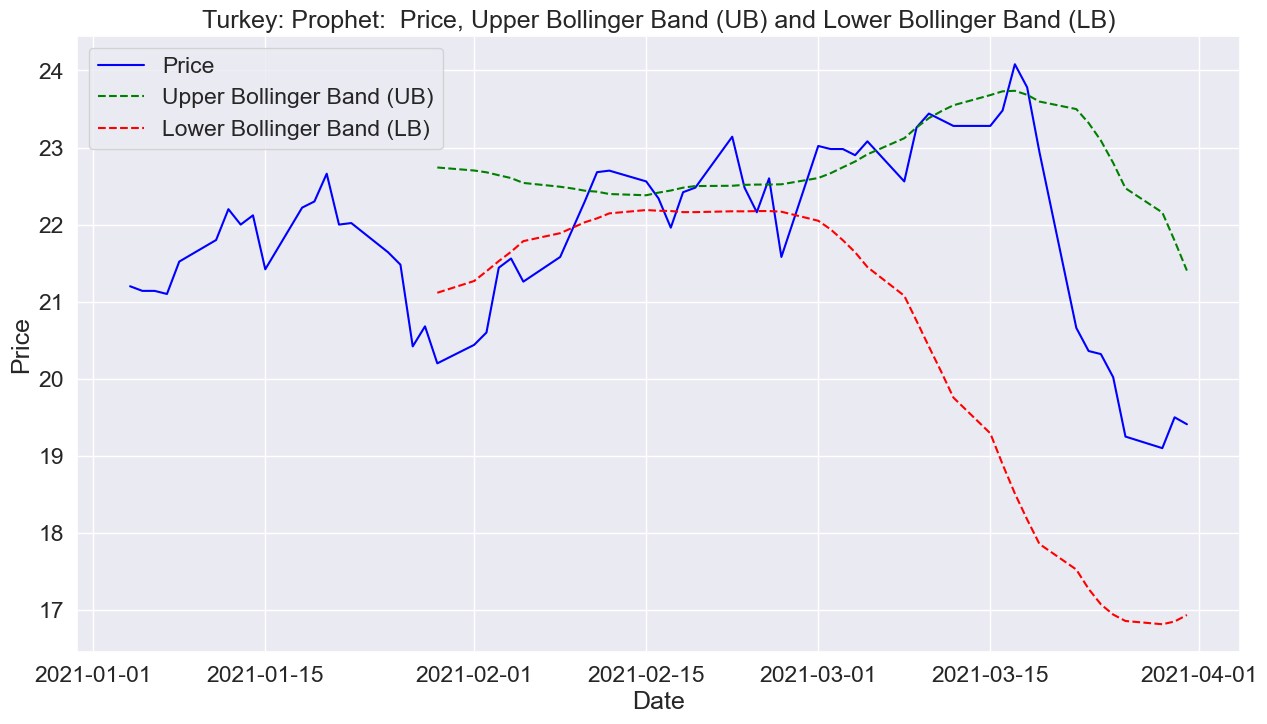

In [166]:
plot_bollinger_bands (dataframe = df_b2,mdl_type = 'Turkey: Prophet',savefig = 'Turkey Bollinger Band Graph  .png')

**Strategy For Turkey**

    From around the last week in January through the end of the first week in February buy. 
    After that, there are some fluctuations in price but the price is primarily between the Bollinger bands so hold.
